<a href="https://colab.research.google.com/github/mbauergit/Disaster-Damage-Level-Classification/blob/main/Graduate_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Graduate project/cv-satellite-images

/content/drive/MyDrive/Colab Notebooks/Graduate project/cv-satellite-images


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import random

from data_utils import get_images, get_labels, load_images
from feature_utils import get_sobel_features, get_gabor_features, generate_gabor_kernel, get_local_binary_pattern

from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.datasets import make_imbalance
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

<ipython-input-3-f3e27d59a4ce>:29: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


# Loading the data
To get started let's first load in the data! We will make use of the helper functions provided in `data_utils.py`

In [ ]:
from data_utils import get_images, get_labels, load_images

The following is the list of disasters in our dataset.

In [ ]:
disaster_list = ["hurricane-matthew", "socal-fire", "midwest-flooding"]

We will load each disaster train dataset into a dictionary. Recall that each disaster consists of images and labels (0 - 3) of the damage level.

In [ ]:
data = {}
split = "train"
with open('config.json') as config_file:
    config = json.load(config_file)
    data_dir = config['data_dir']

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

task_a_test = load_images('/content/drive/MyDrive/Colab Notebooks/Graduate project/satellite-image-data/test_images_flooding-fire.npz')
task_b_test = load_images('/content/drive/MyDrive/Colab Notebooks/Graduate project/satellite-image-data/test_images_hurricane-matthew.npz')

Loading train images and labels for hurricane-matthew dataset...
Loading train images and labels for socal-fire dataset...
Loading train images and labels for midwest-flooding dataset...


Let's visualize an image and its label in the dataset.

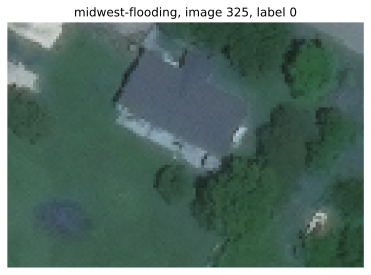

image shape: (86, 125, 3)


In [ ]:
disaster = disaster_list[2]
images = data[disaster]["images"]
labels = data[disaster]["labels"]

# index of the image to display
idx = 325
img = images[idx]
label = labels[idx]

plt.title(f"{disaster}, image {idx}, label {label}")
plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.show()

#
print(f"image shape: {img.shape}")

# Extracting Color Information.
Each image is an RGB image represented as a numpy array of dimensions (width, height, 3). The last dimension corresponds to the RGB *color channels* in the image. We can split the image by color channels and visualize each of them individually.

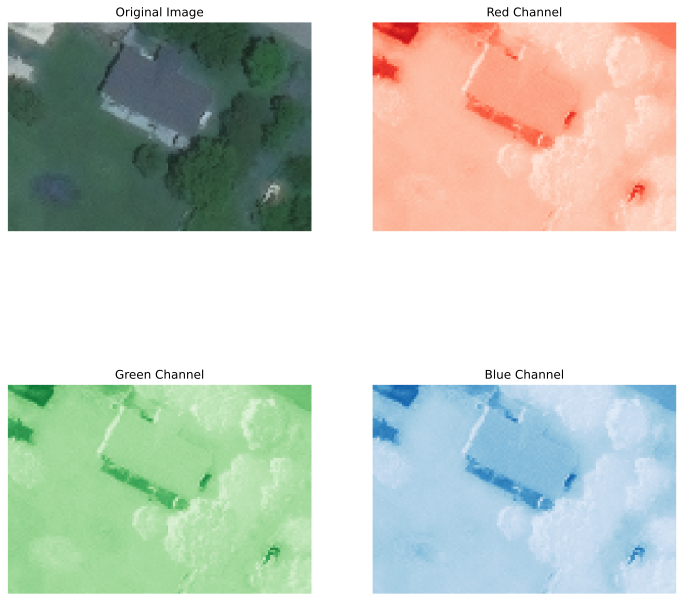

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img[:, :, 0], cmap="Reds", vmin=0, vmax=255)
plt.title("Red Channel")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img[:, :, 1], cmap="Greens", vmin=0, vmax=255)
plt.title("Green Channel")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(img[:, :, 2], cmap="Blues", vmin=0, vmax=255)
plt.title("Blue Channel")
plt.axis("off")

plt.show()

We can zoom in on just a pixel as well.

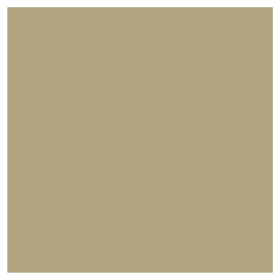

Pixel value: [177 165 128], coordinate: (15, 35)


In [ ]:
coord = (15, 35)
pixel_value = img[coord[0], coord[1], :]
pixel_image = np.array([[pixel_value]])

plt.imshow(pixel_image)
plt.axis("off")
plt.show()

print(f"Pixel value: {pixel_value}, coordinate: {coord}")

# Extracting Edge and Texture Information

So far we have considered the **color** information in an image. However, other important aspects of an image are the edges and texture.

Let us consider some popular feature processing methods for extracting edge and texture information. We will use the utilities provided in `feature_utils.py`.

In [ ]:
from feature_utils import get_sobel_features, get_gabor_features, generate_gabor_kernel, get_local_binary_pattern

Let's try the Sobel Edge Filter.

Read more about Sobel edge detection: https://en.wikipedia.org/wiki/Sobel_operator and https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html

54


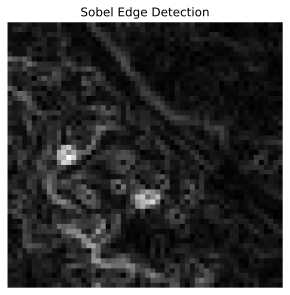

In [ ]:
img = images[2]
edges = get_sobel_features(img)
print(len(edges))
plt.imshow(edges, cmap="gray")
plt.title("Sobel Edge Detection")
plt.axis("off")
plt.show()

Now let's look at local binary patterns.

Read more about LBP: https://en.wikipedia.org/wiki/Local_binary_patterns and https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html

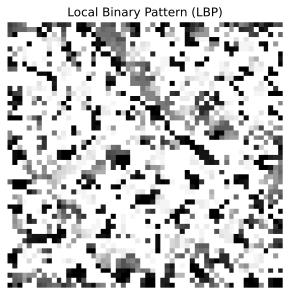

In [ ]:
lbp = get_local_binary_pattern(img, radius=3)
plt.imshow(lbp, cmap="gray")
plt.axis("off")
plt.title("Local Binary Pattern (LBP)")
plt.show()

Another popular filter for image processing is the Gabor filter. The Gabor filters are a family of filters parametrized by orientation, frequency, bandwith, etc. Let's generate one such filter.

Read more about Gabor filters: https://en.wikipedia.org/wiki/Gabor_filter and https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html

In [ ]:
theta = 0
sigma = 1.0
frequency = 0.1

kernel = generate_gabor_kernel(theta, sigma, frequency)
gabor = get_gabor_features(img, kernel)

Let's visualize this filter (aka kernel) and the response of the image when we apply the filter. Concretely we are taking the convolution of the image with the filter. See https://en.wikipedia.org/wiki/Kernel_(image_processing) for more details.

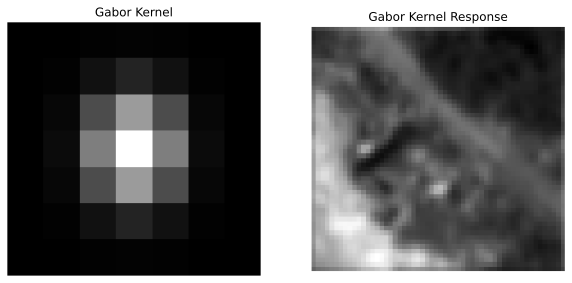

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot Gabor Kernel
axs[0].imshow(kernel, cmap="gray")
axs[0].axis("off")  # Remove axis
axs[0].set_title("Gabor Kernel")

# Plot Gabor Kernel Response
axs[1].imshow(gabor, cmap="gray")
axs[1].axis("off")  # Remove axis
axs[1].set_title("Gabor Kernel Response")

plt.show()

# Data Cleaning and EDA
- Number of images per disaster.
- Image sizes in each dataset. Should ideally observe large variance in sizes, but similar distribution for each disaster.
- Damage labels. Should observe imbalances in the labels.
- (Open-ended) Visualize the distribution of color for different disasters.
- (Open-ended) Convey that the distributions are “separable” somehow.

Number of images in hurricane-matthew: 11151.0
Number of images in socal-fire: 8380.0
Number of images in midwest-flooding: 7004.0


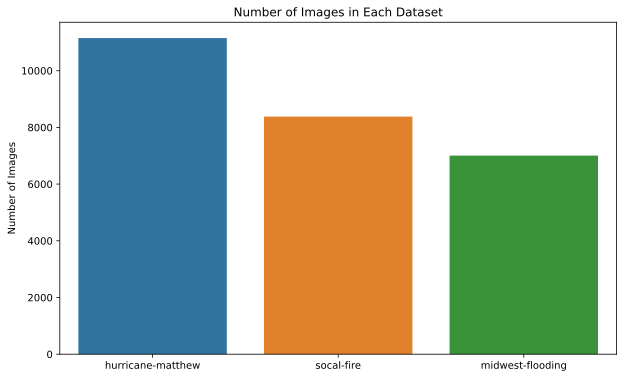

In [ ]:
# Count the number of images in each dataset
num_images = []
for disaster in disaster_list:
    num_images = np.append(num_images, len(data[disaster]["images"]))

print(f"Number of images in {disaster_list[0]}: {num_images[0]}")
print(f"Number of images in {disaster_list[1]}: {num_images[1]}")
print(f"Number of images in {disaster_list[2]}: {num_images[2]}")

# Plot the number of images in each dataset
plt.figure(figsize=(10, 6))
sns.barplot(x=disaster_list, y=num_images, hue=disaster_list)
plt.title("Number of Images in Each Dataset")
plt.ylabel("Number of Images")
plt.show()

Disaster Type  Damage Level 0  Damage Level 1  Damage Level 2  \
0  hurricane-matthew            2631            5236            1544   
1         socal-fire            7204              69              43   
2   midwest-flooding            6734             114              97   

   Damage Level 3  Total Images  
0            1740         11151  
1            1064          8380  
2              59          7004

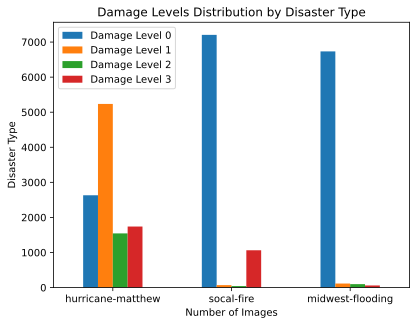

In [ ]:
#Calculate and print the number of images per Damage Level in each disaster type

label_distributions = []

for disaster, info in data.items():
    unique_labels, label_counts = np.unique(info["labels"], return_counts=True)
    total_images = len(info["labels"])
    label_distribution = {f"Damage Level {label}": count for label, count in zip(unique_labels, label_counts)}
    label_distribution["Total Images"] = total_images

    label_distributions.append({"Disaster Type": disaster, **label_distribution})

label_distributions_df = pd.DataFrame(label_distributions)
display(label_distributions_df)

label_counts = {disaster: [0, 0, 0, 0] for disaster in data.keys()}

# Count occurrences of each label for each disaster
for disaster, info in data.items():
    for label in info["labels"]:
        label_counts[disaster][label] += 1

# Convert to DataFrame
label_counts_df = pd.DataFrame(label_counts, index=range(4))

# Plotting
label_counts_df.plot(kind='bar')
plt.xlabel('Damage Level')
plt.ylabel('Number of Images')
plt.title('Damage Levels Distribution by Disaster Type')
plt.legend(title='Type of Disaster')
plt.xticks(rotation=0)
plt.show()

Disaster Type  Mean Height  Mean Width  Std Dev Height  Std Dev Width  \
0  hurricane-matthew    61.485965   60.090485       33.354527      32.097027   
1         socal-fire   101.391527   99.801074       63.169362      59.383312   
2   midwest-flooding    84.223587   82.353798       53.554959      49.512969   

   Max Height  Max Width  Min Height  Min Width  
0         396        354           4          3  
1         890        509           3          4  
2         863        716           6          3

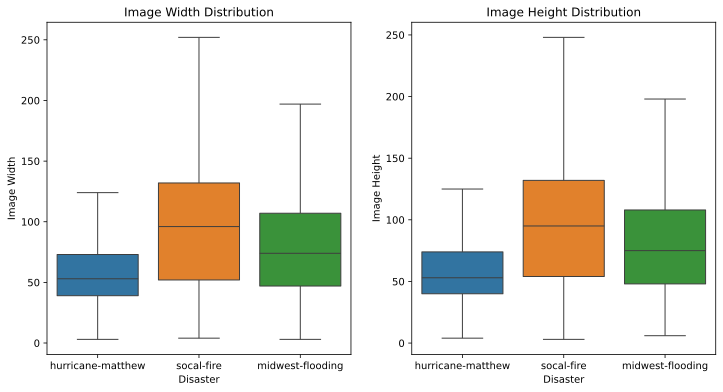

In [ ]:
# Calculate the Width and Height for each image

data_rows = []

for disaster in disaster_list:
    images = data[disaster]["images"]
    labels = data[disaster]["labels"]

    for idx, (img, label) in enumerate(zip(images, labels)):
        data_rows.append({
            "Disaster": disaster,
            "Image Number": idx,
            "Disaster Label": label,
            "Image Shape": img.shape,
            "Image Width": img.shape[0],
            "Image Height": img.shape[1]
        })

images_shape_df = pd.DataFrame(data_rows)
images_shape_df

# Calculate the summary statistics for the image width and height

summary_stats = []

for disaster in disaster_list:
    stats = {
        "Disaster Type": disaster,
        "Mean Height": images_shape_df[images_shape_df["Disaster"] == disaster]["Image Height"].mean(),
        "Mean Width": images_shape_df[images_shape_df["Disaster"] == disaster]["Image Width"].mean(),
        "Std Dev Height": images_shape_df[images_shape_df["Disaster"] == disaster]["Image Height"].std(),
        "Std Dev Width": images_shape_df[images_shape_df["Disaster"] == disaster]["Image Width"].std(),
        "Max Height": images_shape_df[images_shape_df["Disaster"] == disaster]["Image Height"].max(),
        "Max Width": images_shape_df[images_shape_df["Disaster"] == disaster]["Image Width"].max(),
        "Min Height": images_shape_df[images_shape_df["Disaster"] == disaster]["Image Height"].min(),
        "Min Width": images_shape_df[images_shape_df["Disaster"] == disaster]["Image Width"].min()
    }
    summary_stats.append(stats)

summary_stats_df = pd.DataFrame(summary_stats)
display(summary_stats_df)

# Plot the distribution of widhts and heights for each disaster type
figure, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data=images_shape_df, x="Disaster", y="Image Width", hue= "Disaster", showfliers=False, ax=axs[0])
axs[0].set_title("Image Width Distribution")
sns.boxplot(data=images_shape_df, x="Disaster", y="Image Height", hue= "Disaster", showfliers=False, ax=axs[1])
axs[1].set_title("Image Height Distribution")
plt.show()

In [ ]:
#Distribution of color for different disasters
import random

# Randomly sample 100 images for each disaster
sampled_images = {}

for disaster, info in data.items():
    sampled_images[disaster] = random.sample(info["images"], 100)

# Create a dataframe to store RGB values for each pixel
pixel_data = []

for disaster, images in sampled_images.items():
    for img_idx, img in enumerate(images):
        # Assuming damage levels are associated with each image
        damage_level = info["labels"][img_idx]  # Get the damage level for the current image
        for row_idx in range(img.shape[0]):
            for col_idx in range(img.shape[1]):
                pixel_data.append({
                    "Disaster": disaster,
                    "Image Index": img_idx,
                    "Row Index": row_idx,
                    "Column Index": col_idx,
                    "Damage Level": damage_level,
                    "Red Value": img[row_idx, col_idx, 0],
                    "Green Value": img[row_idx, col_idx, 1],
                    "Blue Value": img[row_idx, col_idx, 2]
                })

# Create dataframe from pixel data
pixel_df = pd.DataFrame(pixel_data)
pixel_df

Disaster  Image Index  Row Index  Column Index  \
0        hurricane-matthew            0          0             0   
1        hurricane-matthew            0          0             1   
2        hurricane-matthew            0          0             2   
3        hurricane-matthew            0          0             3   
4        hurricane-matthew            0          0             4   
...                    ...          ...        ...           ...   
2738328   midwest-flooding           99         82            32   
2738329   midwest-flooding           99         82            33   
2738330   midwest-flooding           99         82            34   
2738331   midwest-flooding           99         82            35   
2738332   midwest-flooding           99         82            36   

         Damage Level  Red Value  Green Value  Blue Value  
0                   0        166          190         194  
1                   0        157          181         185  
2                   0        155          179         184  
3                   0        154          177         183  
4                   0        152          174         180  
...               ...        ...          ...         ...  
2738328             0         40           68          54  
2738329             0         38           65          51  
2738330             0         38           66          51  
2738331             0         41           72          54  
2738332             0         37           65          49  

[2738333 rows x 8 columns]

In [ ]:
print(pixel_df.shape)
print(sampled_images.keys())

(2738333, 8)
dict_keys(['hurricane-matthew', 'socal-fire', 'midwest-flooding'])


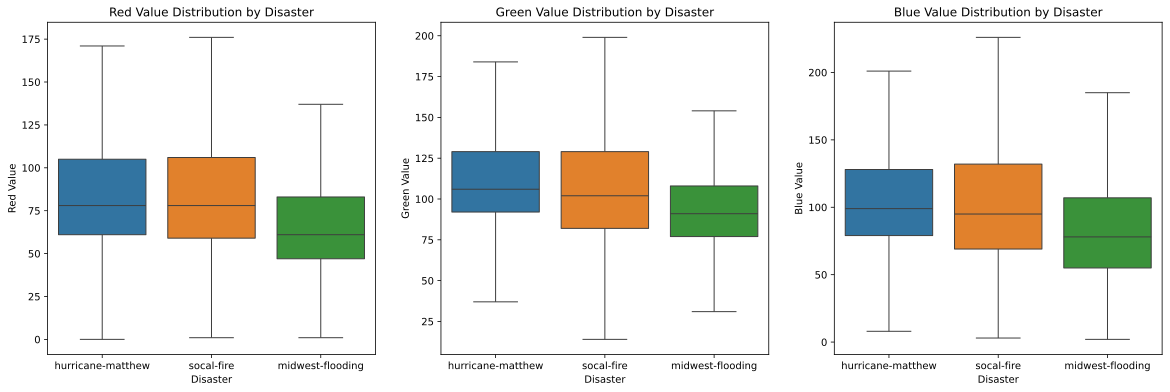

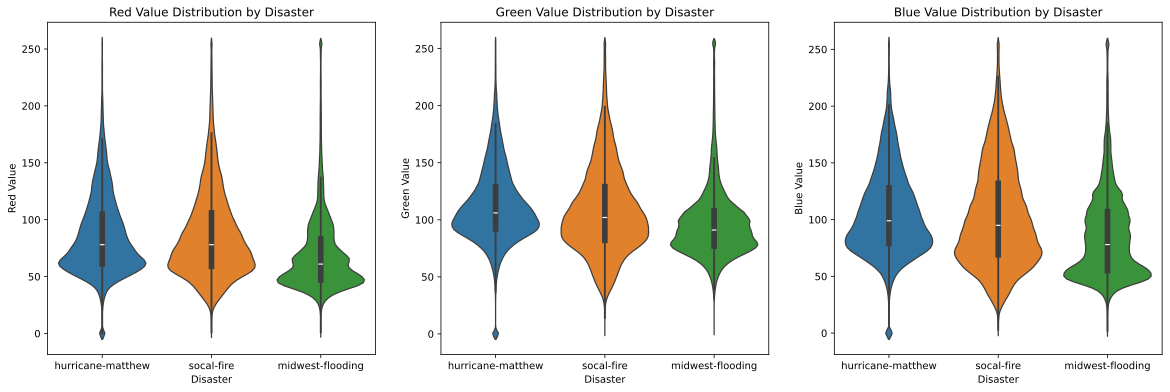

In [ ]:
#visualize the pixel distributions

#split df by disaster type
# fire_df = pixel_df[pixel_df['Disaster'] == 'socal-fire']
# flood_df = pixel_df[pixel_df['Disaster'] == 'midwest-flooding	']
# hurricane_df = pixel_df[pixel_df['Disaster'] == 'hurricane-matthew']

figure, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=pixel_df, x="Disaster", y="Red Value", hue= "Disaster", showfliers=False, ax=axs[0])
axs[0].set_title("Red Value Distribution by Disaster")
sns.boxplot(data=pixel_df, x="Disaster", y="Green Value", hue= "Disaster", showfliers=False, ax=axs[1])
axs[1].set_title("Green Value Distribution by Disaster")
sns.boxplot(data=pixel_df, x="Disaster", y="Blue Value", hue= "Disaster", showfliers=False, ax=axs[2])
axs[2].set_title("Blue Value Distribution by Disaster")
plt.show()

figure, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.violinplot(data=pixel_df, x="Disaster", y="Red Value", hue= "Disaster", ax=axs[0])
axs[0].set_title("Red Value Distribution by Disaster")
sns.violinplot(data=pixel_df, x="Disaster", y="Green Value", hue= "Disaster", ax=axs[1])
axs[1].set_title("Green Value Distribution by Disaster")
sns.violinplot(data=pixel_df, x="Disaster", y="Blue Value", hue= "Disaster", ax=axs[2])
axs[2].set_title("Blue Value Distribution by Disaster")
plt.show()


In [ ]:
#Compare RGB values for different damage levels in hurricane set

#sample new pixels from hurricane matthew, gather at least 20,000 pixels of each damage level

import random

# Dictionary to keep track of sampled pixels for each damage level
sampled_pixels_count = {0: 0, 1: 0, 2: 0, 3: 0}

# Randomly sample images from "hurricane-matthew"
hurricane_matthew_images = random.sample(data["hurricane-matthew"]["images"], 1000)

# Randomly sample pixels until at least 10,000 pixels are sampled for each damage level
pixel_data = []
for img_idx, img in enumerate(hurricane_matthew_images):
    damage_level = data["hurricane-matthew"]["labels"][img_idx]  # Get the damage level for the current image
    for row_idx in range(img.shape[0]):
        for col_idx in range(img.shape[1]):
                pixel_data.append({
                    "Disaster": "hurricane-matthew",
                    "Image Index": img_idx,
                    "Row Index": row_idx,
                    "Column Index": col_idx,
                    "Damage Level": damage_level,
                    "Red Value": img[row_idx, col_idx, 0],
                    "Green Value": img[row_idx, col_idx, 1],
                    "Blue Value": img[row_idx, col_idx, 2]
                })
                sampled_pixels_count[damage_level] += 1

# Create dataframe from pixel data
hurricane_damage_df = pd.DataFrame(pixel_data)

dl_counts = hurricane_damage_df['Damage Level'].value_counts()
print(dl_counts)


Damage Level
1    1999549
0     875450
3     627053
2     609370
Name: count, dtype: int64


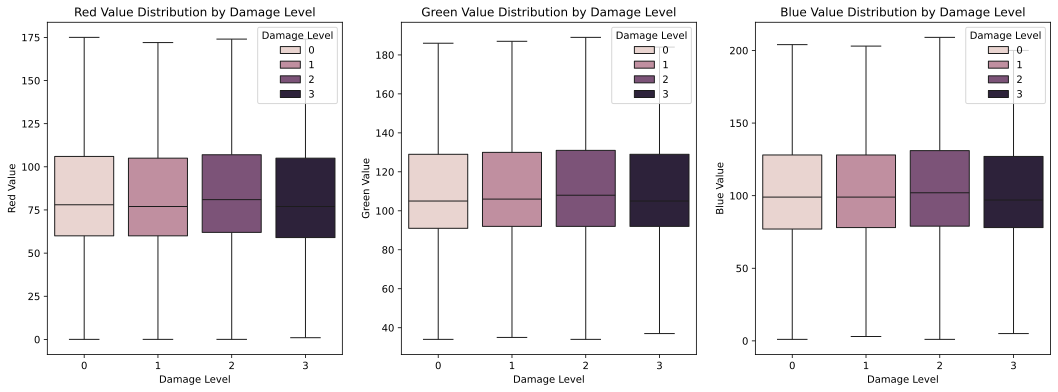

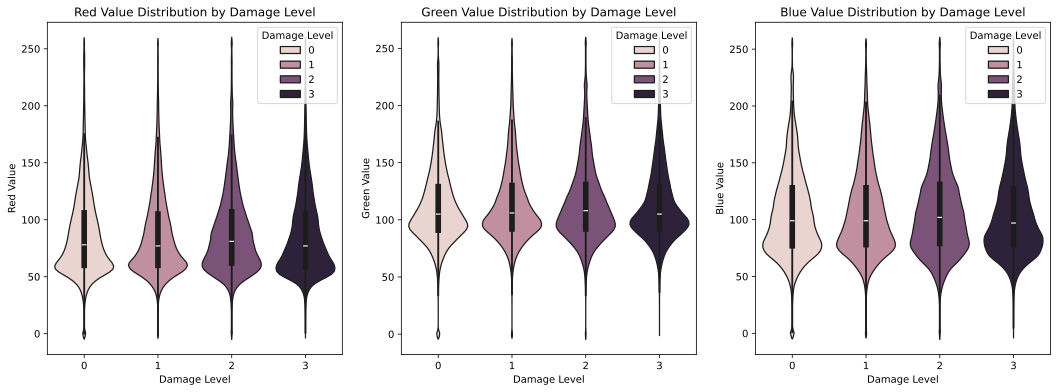

In [ ]:
#visualize distribution of colors for each damage level

figure, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(data=hurricane_damage_df, x='Damage Level', y="Red Value", hue= "Damage Level", showfliers=False, ax=axs[0])
axs[0].set_title("Red Value Distribution by Damage Level")
sns.boxplot(data=hurricane_damage_df, x='Damage Level', y="Green Value", hue= "Damage Level", showfliers=False, ax=axs[1])
axs[1].set_title("Green Value Distribution by Damage Level")
sns.boxplot(data=hurricane_damage_df, x='Damage Level', y="Blue Value", hue= "Damage Level", showfliers=False, ax=axs[2])
axs[2].set_title("Blue Value Distribution by Damage Level")
plt.show()

figure, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(data=hurricane_damage_df, x='Damage Level', y="Red Value", hue= "Damage Level", ax=axs[0])
axs[0].set_title("Red Value Distribution by Damage Level")
sns.violinplot(data=hurricane_damage_df, x='Damage Level', y="Green Value", hue= "Damage Level", ax=axs[1])
axs[1].set_title("Green Value Distribution by Damage Level")
sns.violinplot(data=hurricane_damage_df, x='Damage Level', y="Blue Value", hue= "Damage Level", ax=axs[2])
axs[2].set_title("Blue Value Distribution by Damage Level")
plt.show()

# Task A. Build a classifier that can distinguish images from the midwest-flooding disaster and the socal-fire disaster.



## More EDA to find useful features for our model for Task A.

Let us visually prove the difference in the color histograms for midwest-flooding images vs. socal-fire images; this will give us hints of what features we want to compare in our model.

In [ ]:
# Function taken from https://www.kaggle.com/robinteuwens/plotting-multiple-images-in-one-figure to plot a histogram of color channels

def plot_with_hist_channel(image, channel):
    channels = ["red", "green", "blue"]
    channel_idx = channels.index(channel)
    color = channels[channel_idx]

    extracted_channel = image[:, :, channel_idx]
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(18, 6)
    )  # , sharex=True, sharey=True)

    ax1.imshow(image)
    ax1.axis("off")
    ax2.hist(extracted_channel.ravel(), bins=256, color=color)
    ax2.set_title(f"{channels[channel_idx]} histogram")

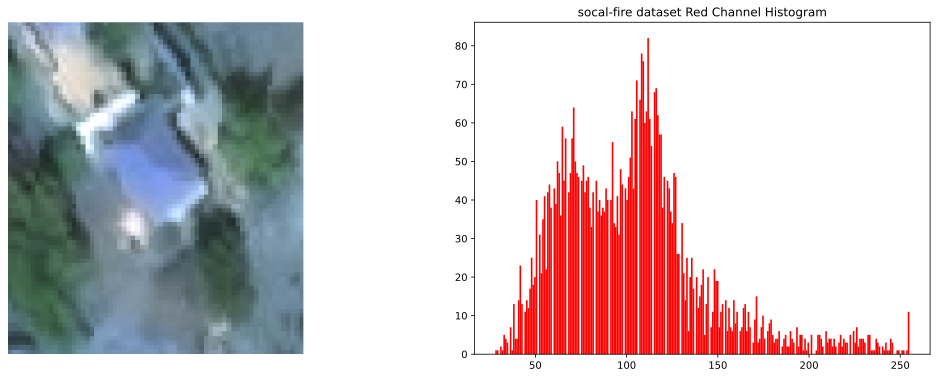

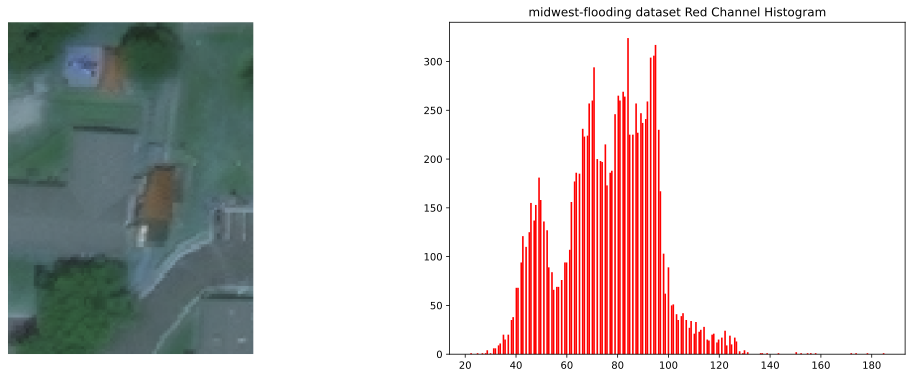

In [ ]:
# This code will plot the histogram of the red channel for a random image in the socal-fire dataset and compare it to the histogram of the red channel for a random image in the midwest-flooding dataset
import random

plot_with_hist_channel(data['socal-fire']['images'][random.randint(0, len(data['socal-fire']["images"]))], 'red')
plt.title("socal-fire dataset Red Channel Histogram")
plot_with_hist_channel(data['midwest-flooding']['images'][random.randint(0, len(data['midwest-flooding']["images"]))], 'red')
plt.title("midwest-flooding dataset Red Channel Histogram")
plt.show()

Instead of using random samples from each disaster type, we apply basic feature engineering for each image. We will try to get the features below and see if they differ from socal-fire and midwest-flooding. We will calculate the mean values and variances of each color band, and we will also calculate the average variance of a grey-transformed image that we will call lightness. Moreover, we will apply the Sobel Edge Filter to the images to see if it helps differentiate the disaster type.

In [ ]:
print(len(data))
# Total images
all_images = {}

for disaster, info in data.items():
    print(len(info["images"]), disaster)
    all_images[disaster] = info["images"]

print(all_images.keys())

# Dictionary to store average RGB values for each image
summary_rgb_values = {}

for disaster, images in all_images.items():
    print("IMAGES: ", len(images))
    for img_idx, img in enumerate(images):
        # Assuming damage levels are associated with each image
        damage_level = data[disaster]["labels"][img_idx]  # Get the damage level for the current image
        gray = rgb2gray(img)
        sobel_edge = get_sobel_features(img)
        # Calculate average RGB values for the current image
        mean_red = np.mean(img[:, :, 0]).astype(float)  # Calculate mean red value
        mean_green = np.mean(img[:, :, 1]).astype(float)  # Calculate mean green value
        mean_blue = np.mean(img[:, :, 2]).astype(float)  # Calculate mean blue value
        var_red = np.var(img[:, :, 0]).astype(float)  # Calculate variance of red value
        var_green = np.var(img[:, :, 1]).astype(float)     # Calculate variance of green value
        var_blue = np.var(img[:, :, 2]).astype(float) # Calculate variance of blue value
        mean_light = np.median(gray).astype(float)  # Calculate the mean value of the gray scaled image
        var_light = np.var(gray).astype(float)  # Calculate the variance of the gray scaled image
        sobel_edge_var = np.var(sobel_edge).astype(float)  # Calculate the variance of the sobel edge image
        sobel_edge_mean = np.mean(sobel_edge).astype(float)  # Calculate the mean of the sobel edge image


        # Store average RGB values in the dictionary
        summary_rgb_values[(disaster, img_idx)] = {
            "Disaster": disaster,
            "Image Index": img_idx,
            "Damage Level": damage_level,
            "Mean Red Value": mean_red,
            "Mean Green Value": mean_green,
            "Mean Blue Value": mean_blue,
            "Var Red Value": var_red,
            "Var Green Value": var_green,
            "Var Blue Value": var_blue,
            "Mean Lightness" : mean_light,
            "Var Lightness" : var_light,
            "Sobel Edge Variance": sobel_edge_var,
            "Sobel Edge Mean": sobel_edge_mean
        }

color_df = pd.DataFrame(summary_rgb_values)

# Transpose the DataFrame
color_df = color_df.transpose()

# Reset the index to ensure proper indexing
color_df = color_df.reset_index(drop=True)

midwest_socal_df = color_df.copy()
midwest_socal_df = midwest_socal_df[(midwest_socal_df['Disaster'] == 'midwest-flooding') | (midwest_socal_df['Disaster'] == 'socal-fire')]
midwest_socal_df

3
11151 hurricane-matthew
8380 socal-fire
7004 midwest-flooding
dict_keys(['hurricane-matthew', 'socal-fire', 'midwest-flooding'])
IMAGES:  11151
IMAGES:  8380
IMAGES:  7004


Disaster Image Index Damage Level Mean Red Value  \
11151        socal-fire           0            0     110.409046   
11152        socal-fire           1            0      70.399918   
11153        socal-fire           2            0      97.319162   
11154        socal-fire           3            0      96.571841   
11155        socal-fire           4            0      76.582532   
...                 ...         ...          ...            ...   
26530  midwest-flooding        6999            0      90.083234   
26531  midwest-flooding        7000            0      95.705306   
26532  midwest-flooding        7001            0      64.786156   
26533  midwest-flooding        7002            0      47.415948   
26534  midwest-flooding        7003            0      58.765634   

      Mean Green Value Mean Blue Value Var Red Value Var Green Value  \
11151        131.51339      126.103811   2614.171428     2161.918624   
11152        89.844771       87.334559    519.542271      668.787996   
11153       122.642376      111.622184   1780.707408     1412.488383   
11154       113.395041      108.018512   1061.727176     1068.248381   
11155       103.573878       99.056731    721.870112      717.058965   
...                ...             ...           ...             ...   
26530        117.02497      109.146254    719.724344      391.903063   
26531       125.348291           122.0   1498.554715       984.17036   
26532        90.175327       77.797965    340.224438      301.833178   
26533        76.151108       59.315271     253.35328      274.796748   
26534        82.899598       69.271658    252.268939      234.049013   

      Var Blue Value Mean Lightness Var Lightness Sobel Edge Variance  \
11151    2696.259344       0.426813      0.035009            0.002715   
11152    1198.832923       0.319748      0.009813            0.001996   
11153    1846.380126       0.429669      0.023048            0.002014   
11154    1370.921476       0.414419      0.016554            0.001629   
11155    1341.912487       0.361823      0.011223            0.001431   
...              ...            ...           ...                 ...   
26530     771.791927       0.402124      0.007289            0.000594   
26531    1529.134972       0.430516       0.01701            0.001557   
26532     638.551842       0.309096      0.004987            0.000415   
26533     490.865259        0.25085      0.004274            0.000477   
26534     567.664297       0.287814      0.003821            0.000343   

      Sobel Edge Mean  
11151        0.048752  
11152        0.046197  
11153        0.043064  
11154        0.044347  
11155        0.037459  
...               ...  
26530        0.024533  
26531         0.03318  
26532        0.024502  
26533        0.021576  
26534        0.021742  

[15384 rows x 13 columns]

Let us visually and numerically find if the features we calculated (mean, variance) significantly differ between the two datasets. If these features are significantly different, we can use them as inputs for our model.

In [ ]:
print('Mean values')
print (f" Is average red value higher in socal-fire than midwest-flodding: {color_df[color_df['Disaster'] == 'socal-fire']['Mean Red Value'].mean() > color_df[color_df['Disaster'] == 'midwest-flooding']['Mean Red Value'].mean()}")
print (f" Is average green value higher in socal-fire than midwest-flodding: {color_df[color_df['Disaster'] == 'socal-fire']['Mean Green Value'].mean() > color_df[color_df['Disaster'] == 'midwest-flooding']['Mean Green Value'].mean()}")
print (f" Is average blue value higher in socal-fire than midwest-flodding: {color_df[color_df['Disaster'] == 'socal-fire']['Mean Blue Value'].mean() > color_df[color_df['Disaster'] == 'midwest-flooding']['Mean Blue Value'].mean()}")

print('Variance values')
print (f" Is variance red value higher in socal-fire than midwest-flodding: {color_df[color_df['Disaster'] == 'socal-fire']['Var Red Value'].mean() > color_df[color_df['Disaster'] == 'midwest-flooding']['Var Red Value'].mean()}")
print (f" Is variance green value higher in socal-fire than midwest-flodding: {color_df[color_df['Disaster'] == 'socal-fire']['Var Green Value'].mean() > color_df[color_df['Disaster'] == 'midwest-flooding']['Var Green Value'].mean()}")
print (f" Is variance blue value higher in socal-fire than midwest-flodding: {color_df[color_df['Disaster'] == 'socal-fire']['Var Blue Value'].mean() > color_df[color_df['Disaster'] == 'midwest-flooding']['Var Blue Value'].mean()}")

print('Lightness values')
print (f" Is average lightness value higher in socal-fire than midwest-flodding: {color_df[color_df['Disaster'] == 'socal-fire']['Mean Lightness'].mean() > color_df[color_df['Disaster'] == 'midwest-flooding']['Mean Lightness'].mean()}")
print (f" Is variance lightness value higher in socal-fire than midwest-flodding: {color_df[color_df['Disaster'] == 'socal-fire']['Var Lightness'].mean() > color_df[color_df['Disaster'] == 'midwest-flooding']['Var Lightness'].mean()}")

print('Sobel Edge values')
print (f" Is average sobel edge value higher in socal-fire than midwest-flodding: {color_df[color_df['Disaster'] == 'socal-fire']['Sobel Edge Mean'].mean() > color_df[color_df['Disaster'] == 'midwest-flooding']['Sobel Edge Mean'].mean()}")
print (f" Is variance sobel edge value higher in socal-fire than midwest-flodding: {color_df[color_df['Disaster'] == 'socal-fire']['Sobel Edge Variance'].mean() > color_df[color_df['Disaster'] == 'midwest-flooding']['Sobel Edge Variance'].mean()}")

Mean values
 Is average red value higher in socal-fire than midwest-flodding: True
 Is average green value higher in socal-fire than midwest-flodding: True
 Is average blue value higher in socal-fire than midwest-flodding: True
Variance values
 Is variance red value higher in socal-fire than midwest-flodding: True
 Is variance green value higher in socal-fire than midwest-flodding: True
 Is variance blue value higher in socal-fire than midwest-flodding: True
Lightness values
 Is average lightness value higher in socal-fire than midwest-flodding: True
 Is variance lightness value higher in socal-fire than midwest-flodding: True
Sobel Edge values
 Is average sobel edge value higher in socal-fire than midwest-flodding: True
 Is variance sobel edge value higher in socal-fire than midwest-flodding: True


We observe that the calculated features differ for images in socal-fire and midwest-flooding. Therefore, the mean and variance of the different color bands, including the grey band, are good values for starting our classification. Let us see the general distribution of histograms of different mean variances for each dataset (midwest-flooding, socal-fire).

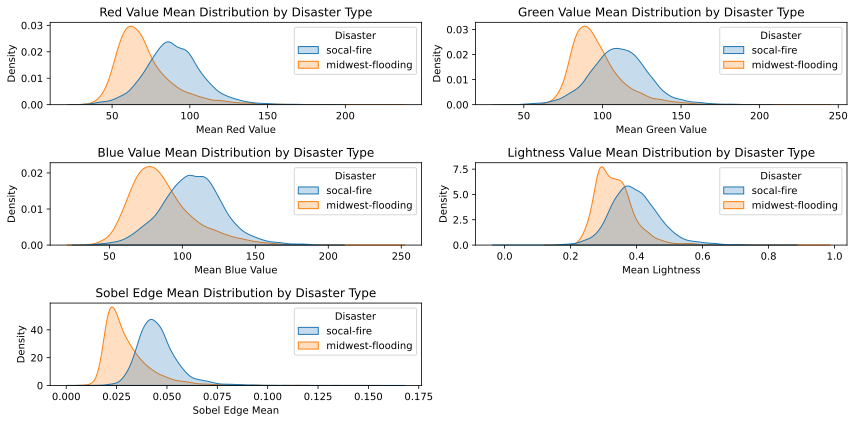

In [ ]:
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the mean red value distribution for each disaster type
ax1=plt.subplot(3, 2, 1)
sns.kdeplot(data=midwest_socal_df, x='Mean Red Value', hue='Disaster', fill=True, common_norm=False, ax=ax1)
ax1.set_title("Red Value Mean Distribution by Disaster Type")


# Plot the mean green value distribution for each disaster type
ax2=plt.subplot(3, 2, 2)
sns.kdeplot(data=midwest_socal_df, x='Mean Green Value', hue='Disaster', fill=True, common_norm=False, ax=ax2)
ax2.set_title("Green Value Mean Distribution by Disaster Type")

# Plot the mean blue value distribution for each disaster type
ax3=plt.subplot(3, 2, 3)
sns.kdeplot(data=midwest_socal_df, x='Mean Blue Value', hue='Disaster', fill=True, common_norm=False, ax=ax3)
ax3.set_title("Blue Value Mean Distribution by Disaster Type")

# Plot the mean lightness value distribution for each disaster type
ax4=plt.subplot(3, 2, 4)
sns.kdeplot(data=midwest_socal_df, x='Mean Lightness', hue='Disaster', fill=True, common_norm=False, ax=ax4)
ax4.set_title("Lightness Value Mean Distribution by Disaster Type")

# Plot the mean sobel edge value distribution for each disaster type
ax5=plt.subplot(3, 2, 5)
sns.kdeplot(data=midwest_socal_df, x='Sobel Edge Mean', hue='Disaster', fill=True, common_norm=False, ax=ax5)
ax5.set_title("Sobel Edge Mean Distribution by Disaster Type")
plt.tight_layout()
plt.show()

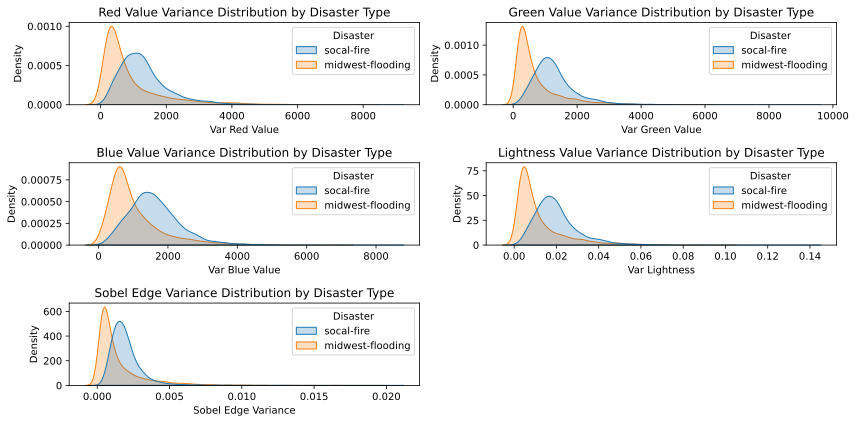

In [ ]:
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the variance red value distribution for each disaster type
ax1=plt.subplot(3, 2, 1)
sns.kdeplot(data=midwest_socal_df, x='Var Red Value', hue='Disaster', fill=True, common_norm=False, ax=ax1)
ax1.set_title("Red Value Variance Distribution by Disaster Type")

# Plot the variance green value distribution for each disaster type
ax2=plt.subplot(3, 2, 2)
sns.kdeplot(data=midwest_socal_df, x='Var Green Value', hue='Disaster', fill=True, common_norm=False, ax=ax2)
ax2.set_title("Green Value Variance Distribution by Disaster Type")

# Plot the variance blue value distribution for each disaster type
ax3=plt.subplot(3, 2, 3)
sns.kdeplot(data=midwest_socal_df, x='Var Blue Value', hue='Disaster', fill=True, common_norm=False, ax=ax3)
ax3.set_title("Blue Value Variance Distribution by Disaster Type")

# Plot the variance lightness value distribution for each disaster type
ax4=plt.subplot(3, 2, 4)
sns.kdeplot(data=midwest_socal_df, x='Var Lightness', hue='Disaster', fill=True, common_norm=False, ax=ax4)
ax4.set_title("Lightness Value Variance Distribution by Disaster Type")

# Plot the variance sobel edge value distribution for each disaster type
ax5=plt.subplot(3, 2, 5)
sns.kdeplot(data=midwest_socal_df, x='Sobel Edge Variance', hue='Disaster', fill=True, common_norm=False, ax=ax5)
ax5.set_title("Sobel Edge Variance Distribution by Disaster Type")
plt.tight_layout()
plt.show()

The histograms show clear differences in the mean and variance values for each color band and also for the grey-scaled image (lightness). They also show that the Sobel Edge Mean and Variance are useful differentiating features.

#### Experiment with removing outliers from dataset to improve model accuracy

In [ ]:
def remove_outliers(data, feature, labels):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    print(f"{feature}: Lower limit = {Q1}, Upper limit = {Q3}")

    # Create a boolean mask for filtering
    mask = (data[feature] >= Q1) & (data[feature] <= Q3)

    # Apply the mask to both data and labels
    filtered_data = data[mask]
    filtered_labels = labels[mask]

    return filtered_data, filtered_labels



We see now that the color mean and variance values differ among the two datasets, as does the variance of the grey scale. The Sobel Edge Filter proves really useful for differentiating the disaster type. These features will then be our approximation.

## Perform the Logistic regression with a single feature (average red value).

To start our modeling, we will use the red band's mean value from midwest-flooding and socal-fire and build a logistic regression to predict the disaster type. We will first use the red value as the only feature of our classification model. Images classified as socal-fire are 1, and midwest-flooding is 0.

In [ ]:
X = midwest_socal_df[['Mean Red Value']]
Y = midwest_socal_df['Disaster']

# Split the data into training and testing sets, we will use 80% of the data for training and 20% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

# Create and train the model
single_feature_model = LogisticRegression()

### Evaluate the model performance.

#### Cross-validation of the single feature logistic regression model.

In [ ]:
# With this we perform a 5-fold cross-validation to evaluate the model performance using the training data and using the accuracy metric
np.random.seed(100)

# n_splits sets the number of folds to create
kf = KFold(n_splits=5, shuffle=True)
validation_accuracy = []
validation_precision = []
validation_recall = []
validation_FPR = []

for train_idx, valid_idx in kf.split(X_train):
    # Split the data
    split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

    # Fit the model on the training split
    single_feature_model.fit(split_X_train, split_Y_train)
    Y_valid_predict = single_feature_model.predict(split_X_valid)

    tp = np.sum((Y_valid_predict == 'socal-fire') & (split_Y_valid == 'socal-fire'))
    tn = np.sum((Y_valid_predict == 'midwest-flooding') & (split_Y_valid == 'midwest-flooding'))
    fp = np.sum((Y_valid_predict == 'socal-fire') & (split_Y_valid == 'midwest-flooding'))
    fn = np.sum((Y_valid_predict == 'midwest-flooding') & (split_Y_valid == 'socal-fire'))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    FPR = fp / (fp + tn)

    validation_accuracy.append(accuracy)
    validation_precision.append(precision)
    validation_recall.append(recall)
    validation_FPR.append(FPR)

print(f"Cross-validation accuracy: {np.mean(validation_accuracy)}")
print(f"Cross-validation precision: {np.mean(validation_precision)}")
print(f"Cross-validation recall: {np.mean(validation_recall)}")
print(f"Cross-validation FPR: {np.mean(validation_FPR)}")

Cross-validation accuracy: 0.7500615119833661
Cross-validation precision: 0.7666396431539557
Cross-validation recall: 0.776870734801623
Cross-validation FPR: 0.2816508062587632


#### Evaluation of the single feature model with our test dataset.

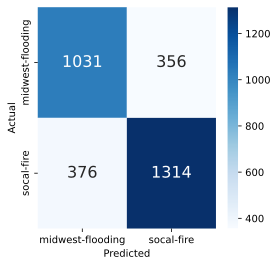

In [ ]:
# First we want to analize the confusion matrix for the test data
Y_predict = single_feature_model.predict(X_test)

cm = confusion_matrix(Y_test, Y_predict)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16}, xticklabels=['midwest-flooding', 'socal-fire'], yticklabels=['midwest-flooding', 'socal-fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [ ]:
# And with the confusion matrix we proceed to calculate the accuracy, precision, recall and FPR

tp = np.sum((Y_predict == 'socal-fire') & (Y_test == 'socal-fire'))
tn = np.sum((Y_predict == 'midwest-flooding') & (Y_test == 'midwest-flooding'))
fp = np.sum((Y_predict == 'socal-fire') & (Y_test == 'midwest-flooding'))
fn = np.sum((Y_predict == 'midwest-flooding') & (Y_test == 'socal-fire'))

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
FPR = fp / (fp + tn)

print(f"Accuracy: {accuracy}"),
print(f"{np.round(accuracy * 100)}% of the test data was classified correctly.")

print(f"Precision: {precision}")
print(f"{np.round(precision * 100)}% of the images classified as socal-fire were actually socal-fire.")

print(f"Recall: {recall}")
print(f"{np.round(recall * 100)}% of the actual socal-fire images were classified as socal-fire.")

print(f"FPR: {FPR}")
print(f"{np.round(FPR * 100)}% of the actual midwest-flooding images were classified as socal-fire.")

### Visualize the single feature model results.

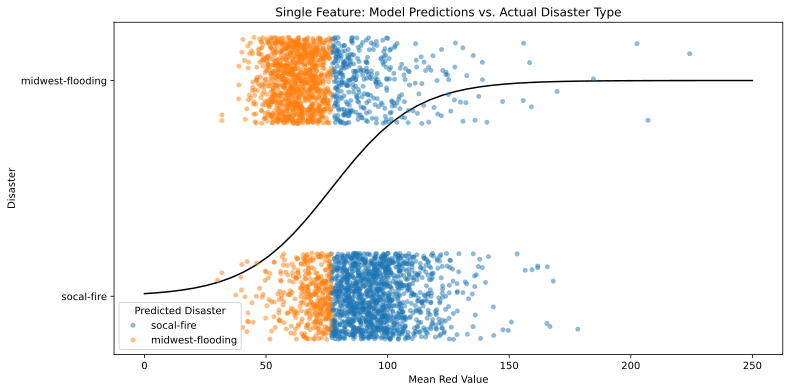

In [ ]:
# Let's visualize the performance of our model

def sigmoid(z):
    return 1/(1+np.exp(-z))

x = np.linspace(0, 250)
single_feature_df = pd.DataFrame({'Mean Red Value': X_test['Mean Red Value'], 'Disaster': Y_test, 'Predicted Disaster': Y_predict})
plt.figure(figsize=(12, 6))
sns.stripplot(data=single_feature_df, x='Mean Red Value', y='Disaster', hue='Predicted Disaster', alpha=0.5, jitter=0.2)
plt.plot(x, sigmoid(single_feature_model.intercept_ + single_feature_model.coef_[0]*x), 'k')
plt.gca().invert_yaxis();
plt.title("Single Feature: Model Predictions vs. Actual Disaster Type");

 The previous analysis shows that the model performs relatively well when only one feature is used. In the next section, we will use all the features to train the model and see if we can improve its performance.

## Perform the Logistic regression with multiple features (mean, variance, lightness, Sobel Edge filter) for all the color channels.

Let us now use the three color bands (Red, Green, and Blue) as features of our logistic regression model to predict the disaster type. We will use the summary statistic for each color band, the grey-transformed image, and the log values of the Sobel Edge summary statistics. We will use the log values of these last features because the distribution is skewed, so we want to have a more symmetric distribution of these values.

In [ ]:
midwest_socal_df['Log Sobel Mean'] = np.log(midwest_socal_df['Sobel Edge Mean'].astype(float)+0.000000000000000001)
midwest_socal_df['Log Sobel Var'] = np.log(midwest_socal_df['Sobel Edge Variance'].astype(float)+0.000000000000000001)

X = midwest_socal_df[['Mean Red Value', \
                      'Mean Green Value',
                      'Mean Blue Value', \
                      'Var Red Value',\
                      'Var Green Value',\
                      'Var Blue Value',\
                      'Var Lightness',\
                      'Log Sobel Mean',\
                      'Log Sobel Var'
                      ]]

Y = midwest_socal_df['Disaster']

# Split the data into training and testing sets, we will use 80% of the data for training and 20% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# X_train, Y_train = remove_outliers(X_train, 'Average Red Value', Y_train)
# X_train, Y_train = remove_outliers(X_train, 'Average Green Value', Y_train)
# X_train, Y_train = remove_outliers(X_train, 'Average Blue Value', Y_train)
# Oversampling

# # Create an instance of RandomOverSampler
# oversampler = RandomOverSampler(random_state=42)

# # Fit and transform the training data
# X_train, Y_train = oversampler.fit_resample(X_train, Y_train)

# Y_train_resampled_counts = pd.Series(Y_train).value_counts()
# print("New Y_train counts: ", Y_train_resampled_counts)

# Create and train the model
multiple_feature_model = LogisticRegression(max_iter=1000, penalty='l2')

### Evaluate the model performance.

#### Cross-validation of the multiple-feature logistic regression model.

In [ ]:
# With this we perform a 5-fold cross-validation to evaluate the model performance using the training data and using the accuracy metric
np.random.seed(100)

# n_splits sets the number of folds to create
kf = KFold(n_splits=5, shuffle=True)
validation_accuracy = []
validation_precision = []
validation_recall = []
validation_FPR = []

for train_idx, valid_idx in kf.split(X_train):
    # Split the data
    split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

    # Fit the model on the training split
    multiple_feature_model.fit(split_X_train, split_Y_train)
    Y_valid_predict = multiple_feature_model.predict(split_X_valid)

    tp = np.sum((Y_valid_predict == 'socal-fire') & (split_Y_valid == 'socal-fire'))
    tn = np.sum((Y_valid_predict == 'midwest-flooding') & (split_Y_valid == 'midwest-flooding'))
    fp = np.sum((Y_valid_predict == 'socal-fire') & (split_Y_valid == 'midwest-flooding'))
    fn = np.sum((Y_valid_predict == 'midwest-flooding') & (split_Y_valid == 'socal-fire'))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    FPR = fp / (fp + tn)

    validation_accuracy.append(accuracy)
    validation_precision.append(precision)
    validation_recall.append(recall)
    validation_FPR.append(FPR)

print(f"Cross-validation accuracy: {np.mean(validation_accuracy)}")
print(f"Cross-validation precision: {np.mean(validation_precision)}")
print(f"Cross-validation recall: {np.mean(validation_recall)}")
print(f"Cross-validation FPR: {np.mean(validation_FPR)}")

Cross-validation accuracy: 0.9362149945320846
Cross-validation precision: 0.935105231670699
Cross-validation recall: 0.9488208524288904
Cross-validation FPR: 0.07899625644560433


#### Test the model's accuracy using the test data we split from our sample.

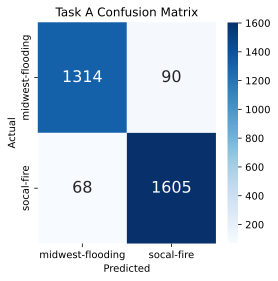

In [ ]:
Y_predict = multiple_feature_model.predict(X_test)

cm = confusion_matrix(Y_test, Y_predict)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16}, xticklabels=['midwest-flooding', 'socal-fire'], yticklabels=['midwest-flooding', 'socal-fire'])
plt.title('Task A Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [ ]:
tp = np.sum((Y_predict == 'socal-fire') & (Y_test == 'socal-fire'))
tn = np.sum((Y_predict == 'midwest-flooding') & (Y_test == 'midwest-flooding'))
fp = np.sum((Y_predict == 'socal-fire') & (Y_test == 'midwest-flooding'))
fn = np.sum((Y_predict == 'midwest-flooding') & (Y_test == 'socal-fire'))

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
FPR = fp / (fp + tn)

print(f"Accuracy: {accuracy}"),
print(f"{np.round(accuracy * 100)}% of the test data was classified correctly.")

print(f"Precision: {precision}")
print(f"{np.round(precision * 100)}% of the images classified as socal-fire were actually socal-fire.")

print(f"Recall: {recall}")
print(f"{np.round(recall * 100)}% of the actual socal-fire images were classified as socal-fire.")

print(f"FPR: {FPR}")
print(f"{np.round(FPR * 100)}% of the actual midwest-flooding images were classified as socal-fire.")

Accuracy: 0.9486512837179071
95.0% of the test data was classified correctly.
Precision: 0.9469026548672567
95.0% of the images classified as socal-fire were actually socal-fire.
Recall: 0.9593544530783025
96.0% of the actual socal-fire images were classified as socal-fire.
FPR: 0.0641025641025641
6.0% of the actual midwest-flooding images were classified as socal-fire.


AUC: 0.9754556616481302


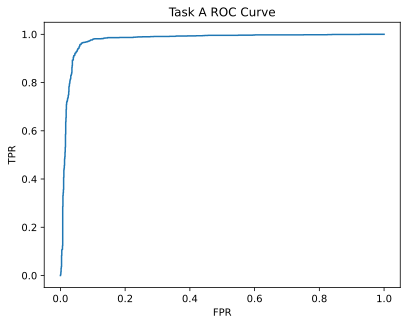

In [ ]:
# plot ROC Curve
train_prob = multiple_feature_model.predict_proba(X_test)
bin_labels = Y_test.replace({'socal-fire': 1, 'midwest-flooding': 0})

fpr, tpr, thresholds = roc_curve(bin_labels, train_prob[:,1])

plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Task A ROC Curve");

AUC = np.trapz(tpr, fpr)
print(f"AUC: {AUC}")

The AUC is ~0.97, close to 1, indicating that the model is very good at distinguishing between the two classes.

### Visualize and explore the model parameters and coefficients.

The model with multiple features seems good for classifying the socal-fire and midwest-flooding images using eight features (average red, green, and blue values and the variance of the red, green, blue colors, log sobel variance, and log sobel mean). Now, we will explore if these features have some colinearity and if we can make our model simpler, equally accurate, and precise.

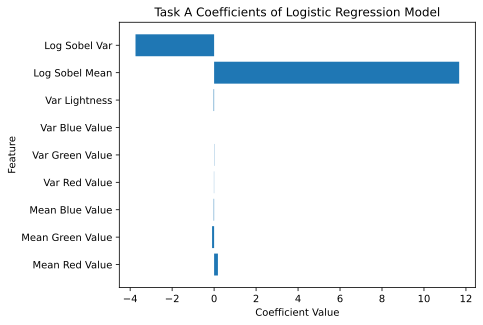

In [ ]:
plt.barh(X.columns, multiple_feature_model.coef_[0])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Task A Coefficients of Logistic Regression Model')
plt.show()

### Calculate confidence intervals for each parameter of the multiple feature model to test colinearity.

In [ ]:
# First we define all the functions we use for calculating the confidence intervals

# Funtuion to calculate all thetas for a sample
def all_thetas(sample):
    # first feature
    model = LogisticRegression(max_iter=1000).fit(
        sample[['Mean Red Value', 'Mean Green Value', 'Mean Blue Value', 'Var Red Value', 'Var Green Value', 'Var Blue Value', 'Var Lightness', 'Log Sobel Mean', 'Log Sobel Var']],
        sample['Disaster'])
    return [model.intercept_[0]] + model.coef_[0].tolist()

# Function to iterate multiple times to get the bootstrap samples and calculate the statistics which is the theta values
def bootstrap(sample, statistic, num_repetitions=1000):
    """
    Returns the statistic computed on a num_repetitions
    bootstrap samples from sample.
    """
    stats = []
    for i in np.arange(num_repetitions):
        # Step 1: Sample the Sample
        bootstrap_sample = sample.sample(frac=1, replace=True)
        # Step 2: compute statistics on the sample of the sample
        bootstrap_stat = statistic(bootstrap_sample)
        # Accumulate the statistics
        stats.append(bootstrap_stat)
    return stats

# Function to calculate the confidence interval
def bootstrap_ci(bootstrap_samples, confidence_level=95):
    """
    Returns the confidence interval for the bootstrap samples.
    """
    lower_percentile = (100 - confidence_level) / 2
    upper_percentile = 100 - lower_percentile
    return np.percentile(bootstrap_samples, [lower_percentile, upper_percentile])

In [ ]:
# And here we calculate the confidence intervals for the features we are using in our multiple feature model, we will use 1000 bootstrap samples
bs_thetas = pd.DataFrame(
    bootstrap(midwest_socal_df, all_thetas, 1000),
    columns=['intercept', 'Mean Red Value', 'Mean Green Value', 'Mean Blue Value', 'Var Red Value', 'Var Green Value', 'Var Blue Value', 'Var Lightness', 'Log Sobel Mean', 'Log Sobel Var'])

(bs_thetas.apply(bootstrap_ci)
    .T
    .rename(columns={0: 'lower', 1: 'upper'}))

lower      upper
intercept         0.061122  13.149890
Mean Red Value    0.126182   0.184506
Mean Green Value -0.113779  -0.021147
Mean Blue Value  -0.042839   0.000625
Var Red Value    -0.010781  -0.008096
Var Green Value   0.010265   0.014820
Var Blue Value   -0.001063  -0.000227
Var Lightness    -0.028504  -0.002848
Log Sobel Mean    9.870506  12.877318
Log Sobel Var    -4.434096  -3.732930

We see that only one of the parameters for our features has a value of 0, which is the mean blue value. Notwithstanding, the coefficient of this parameter is too low to modify our model performance. The remaining features we use are good enough to predict the disaster type.

We could build the best logistic regression model using nine features and an intercept term. We saw through bootstrap sampling that the coefficients for each of our features do not include 0. However, many coefficients have low absolute values, which can attest to some degree of collinearity. We avoided overfitting the model by using a 5-fold cross-validation and tested the model's results in a 20% test dataset. Our classification model for disaster type between socal-fire and midwest-flooding is an excellent first approximation and intuitive model that can be explained easily.

# Task B. Build a classifier that can detect damage level of hurricane-matthew dataset.

## More EDA to find useful features for our model for Task B.

Let us apply some filters to the pixels to obtain new valuable features because, as we have seen in our first general EDA, the color values do not help differentiate between damage levels. Exploring the images, we note that strong borders characterize the images with low damage levels and, therefore, a significant variance in the edge_sobel detection.

### Sobel Edge Detection

In [ ]:
# Example of images with damage level 0 and 3

plt.figure(figsize=(18, 6))

ax1=plt.subplot(1, 4, 1)
ax1.imshow(data['hurricane-matthew']['images'][3])
ax1.set_title("Damage level 0")

ax2=plt.subplot(1, 4, 2)
sns.heatmap(get_sobel_features(data['hurricane-matthew']['images'][3]))

ax3=plt.subplot(1, 4, 3)
ax3.imshow(data['hurricane-matthew']['images'][0])
ax3.set_title("Damage Level 3")

ax4=plt.subplot(1, 4, 4)
sns.heatmap(get_sobel_features(data['hurricane-matthew']['images'][0]))
plt.show()

Let us apply some feature engineering to the Sobel Edge values, such as the variance for each image and the proportion of pixels in different bins of the Edge Sobel Value. To avoid skewed distributions, we will use Log Values instead of raw values for the Mean and Variance.

In [ ]:
#Let's calculate the proportion of pixels within different bins
hurricane_images = data['hurricane-matthew']['images']
hurricane_labels = data['hurricane-matthew']['labels']

edge_proportion_df= []

for img_idx, img in enumerate(hurricane_images):
    # Assuming damage levels are associated with each image
    damage_level = hurricane_labels[img_idx]  # Get the damage level for the current image
    sobel_edge = get_sobel_features(img)
    total_pixels = np.size(sobel_edge)
    edge_proportion_df.append({
        "Disaster": "hurricane-matthew",
        "Image Index": img_idx,
        "Damage Level": damage_level,
        "Sobel Edge Log Variance": np.log(np.var(sobel_edge) + 0.000000000001),
        "Sobel Edge Log Mean": np.log(np.mean(sobel_edge) + 0.000000000001),
        "Edges 0-0.1": np.sum((sobel_edge >= 0) & (sobel_edge < 0.1)) / total_pixels,
        "Edges 0.1-0.2": np.sum((sobel_edge >= 0.1) & (sobel_edge < 0.2)) / total_pixels,
        "Edges 0.2-0.3": np.sum((sobel_edge >= 0.2) & (sobel_edge < 0.3)) / total_pixels,
        "Edges 0.3-0.4": np.sum((sobel_edge >= 0.3) & (sobel_edge < 0.4)) / total_pixels,
        "Edges 0.4-0.5": np.sum((sobel_edge >= 0.4) & (sobel_edge < 0.5)) / total_pixels,
        "Edges 0.5-0.6": np.sum((sobel_edge >= 0.5) & (sobel_edge < 0.6)) / total_pixels,
        "Total": total_pixels
    })

edge_proportion_df= pd.DataFrame(edge_proportion_df)
edge_proportion_df

Disaster  Image Index  Damage Level  Sobel Edge Log Variance  \
0      hurricane-matthew            0             3                -5.833783   
1      hurricane-matthew            1             0                -6.610627   
2      hurricane-matthew            2             1                -5.713512   
3      hurricane-matthew            3             0                -6.829892   
4      hurricane-matthew            4             2                -5.953618   
...                  ...          ...           ...                      ...   
11146  hurricane-matthew        11146             3                -6.360614   
11147  hurricane-matthew        11147             0                -6.891280   
11148  hurricane-matthew        11148             2                -5.582180   
11149  hurricane-matthew        11149             3                -7.871026   
11150  hurricane-matthew        11150             0                -4.838701   

       Sobel Edge Log Mean  Edges 0-0.1  Edges 0.1-0.2  Edges 0.2-0.3  \
0                -2.862324     0.856125       0.115385       0.021368   
1                -3.281083     0.925800       0.068941       0.005259   
2                -2.703878     0.805556       0.162698       0.023148   
3                -3.652390     0.965337       0.027518       0.005589   
4                -2.735583     0.795470       0.183232       0.018932   
...                    ...          ...            ...            ...   
11146            -2.997556     0.878293       0.115399       0.006308   
11147            -3.470095     0.948929       0.047500       0.003571   
11148            -2.632062     0.774150       0.174603       0.042177   
11149            -3.451407     0.995109       0.004891       0.000000   
11150            -2.661341     0.821622       0.082432       0.047297   

       Edges 0.3-0.4  Edges 0.4-0.5  Edges 0.5-0.6  Total  
0           0.006268       0.000855       0.000000   3510  
1           0.000000       0.000000       0.000000   7035  
2           0.005622       0.002646       0.000331   3024  
3           0.001486       0.000071       0.000000  14136  
4           0.002028       0.000338       0.000000   2958  
...              ...            ...            ...    ...  
11146       0.000000       0.000000       0.000000   2695  
11147       0.000000       0.000000       0.000000   2800  
11148       0.007710       0.001361       0.000000   2205  
11149       0.000000       0.000000       0.000000   1840  
11150       0.037838       0.009459       0.001351   1480  

[11151 rows x 12 columns]

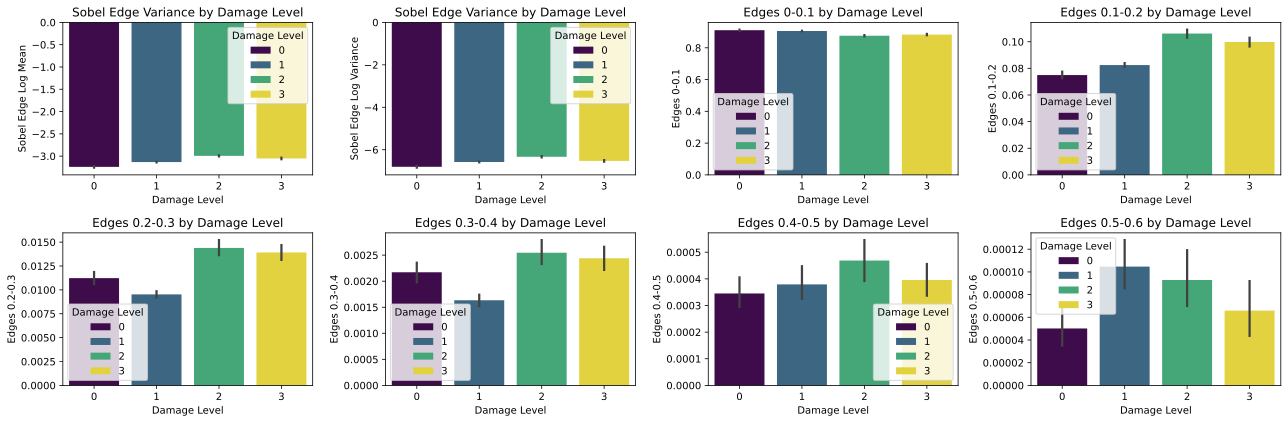

In [ ]:
plt.figure(figsize=(18, 6))

ax1=plt.subplot(2, 4, 1)
sns.barplot(data=edge_proportion_df, x='Damage Level', y='Sobel Edge Log Mean', hue='Damage Level', palette='viridis', ax=ax1)
ax1.set_title("Sobel Edge Variance by Damage Level")

ax2=plt.subplot(2, 4, 2)
sns.barplot(data=edge_proportion_df, x='Damage Level', y='Sobel Edge Log Variance', hue='Damage Level', palette='viridis', ax=ax2)
ax2.set_title("Sobel Edge Variance by Damage Level")

ax3=plt.subplot(2, 4, 3)
sns.barplot(data=edge_proportion_df, x='Damage Level', y='Edges 0-0.1',hue='Damage Level', palette='viridis', ax=ax3)
ax3.set_title("Edges 0-0.1 by Damage Level")

ax4=plt.subplot(2, 4, 4)
sns.barplot(data=edge_proportion_df, x='Damage Level', y='Edges 0.1-0.2',hue='Damage Level', palette='viridis', ax=ax4)
ax4.set_title("Edges 0.1-0.2 by Damage Level")

ax5=plt.subplot(2, 4, 5)
sns.barplot(data=edge_proportion_df, x='Damage Level', y='Edges 0.2-0.3',hue='Damage Level', palette='viridis', ax=ax5)
ax5.set_title("Edges 0.2-0.3 by Damage Level")

ax6=plt.subplot(2, 4, 6)
sns.barplot(data=edge_proportion_df, x='Damage Level', y='Edges 0.3-0.4',hue='Damage Level', palette='viridis', ax=ax6)
ax6.set_title("Edges 0.3-0.4 by Damage Level")

ax7=plt.subplot(2, 4, 7)
sns.barplot(data=edge_proportion_df, x='Damage Level', y='Edges 0.4-0.5',hue='Damage Level', palette='viridis', ax=ax7)
ax7.set_title("Edges 0.4-0.5 by Damage Level")

ax8=plt.subplot(2, 4, 8)
sns.barplot(data=edge_proportion_df, x='Damage Level', y='Edges 0.5-0.6',hue='Damage Level', palette='viridis', ax=ax8)
ax8.set_title("Edges 0.5-0.6 by Damage Level")

plt.tight_layout()
plt.show()

We start to see that applying filters to each image, calculating summaries as the mean and variance, and counting the number of pixels with a resulting value in a determined bin helps engineer features useful for classification.

### Gabor Filter

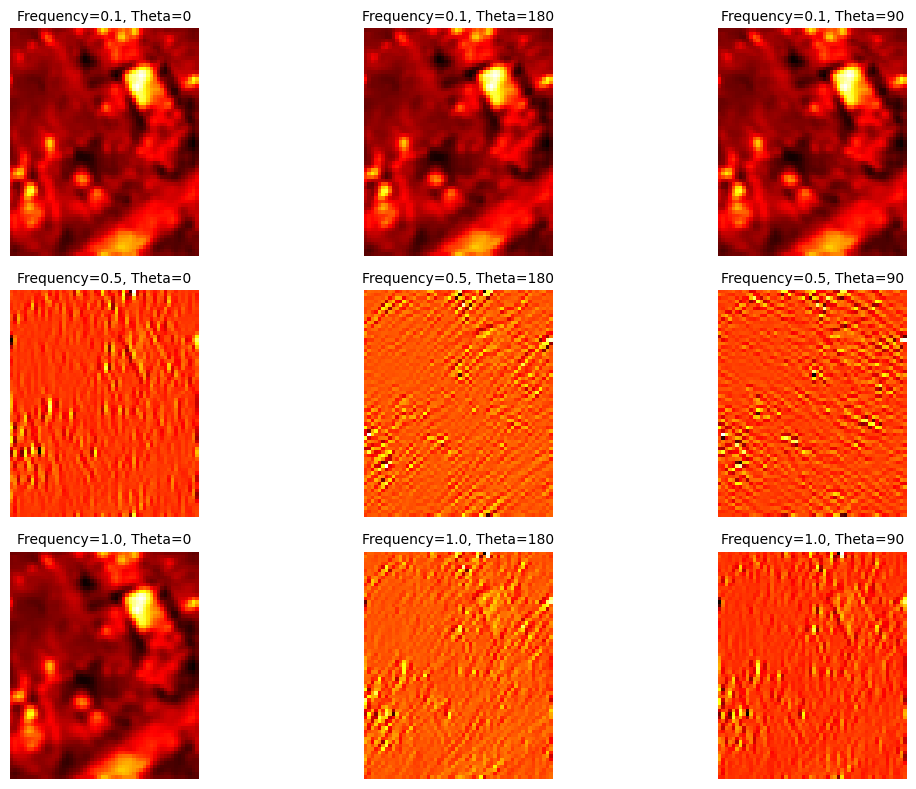

In [ ]:
# Let us explore the Gabor filters with differen parameters

sigma = 1
img = data['hurricane-matthew']['images'][0]
frequencies = [0.1, 0.5, 1.0]
thetas = [0, 180, 90]

plt.figure(figsize=(12, 8))
for i, frequency in enumerate(frequencies):
    for j, theta in enumerate(thetas):
        kernel = generate_gabor_kernel(theta, sigma, frequency)
        gabor = get_gabor_features(img, kernel)

        plt.subplot(len(frequencies), len(thetas), i*len(thetas) + j + 1)
        plt.imshow(gabor, cmap='hot')
        plt.title(f"Frequency={frequency}, Theta={theta}", fontsize = 10)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Now we will generate a dataframe with the values of the Gabor Filter Variance and mean that can be usedul as features for classification
hurricane_images = data['hurricane-matthew']['images']
hurricane_labels = data['hurricane-matthew']['labels']

gabor_df = []

for img_idx, img in enumerate(hurricane_images):
    # Assuming damage levels are associated with each image
    damage_level = hurricane_labels[img_idx]  # Get the damage level for the current image
    frequency = 0.6
    theta = 90
    sigma = 1
    kernel = generate_gabor_kernel(theta, sigma, frequency)
    gabor = get_gabor_features(img, kernel)
    total_pixels = np.size(gabor)
    gabor_df.append({
        "Disaster": "hurricane-matthew",
        "Image Index": img_idx,
        "Damage Level": damage_level,
        "Gabor Variance": np.var(gabor),
        "Gabor Log Variance": np.log(np.var(gabor) + 0.000000000001),
        "Gabor Mean": np.mean(gabor),
        "Gabor Log Mean": np.log(np.mean(gabor) + 0.000000000001),
    })

gabor_df= pd.DataFrame(gabor_df)
gabor_df

Disaster  Image Index  Damage Level  Gabor Variance  \
0      hurricane-matthew            0             3        0.000099   
1      hurricane-matthew            1             0        0.000006   
2      hurricane-matthew            2             1        0.000158   
3      hurricane-matthew            3             0        0.000004   
4      hurricane-matthew            4             2        0.000011   
...                  ...          ...           ...             ...   
11146  hurricane-matthew        11146             3        0.000011   
11147  hurricane-matthew        11147             0        0.000004   
11148  hurricane-matthew        11148             2        0.000144   
11149  hurricane-matthew        11149             3        0.000027   
11150  hurricane-matthew        11150             0        0.000036   

       Gabor Log Variance  Gabor Mean  Gabor Log Mean  
0               -9.222105    0.001636       -6.415277  
1              -12.026272    0.001860       -6.287148  
2               -8.750069    0.001986       -6.221673  
3              -12.502409    0.002019       -6.205292  
4              -11.413253    0.001713       -6.369710  
...                   ...         ...             ...  
11146          -11.436481    0.001740       -6.354030  
11147          -12.455529    0.001621       -6.424617  
11148           -8.843826    0.001699       -6.377463  
11149          -10.505202    0.001236       -6.695667  
11150          -10.228947    0.002040       -6.194654  

[11151 rows x 7 columns]

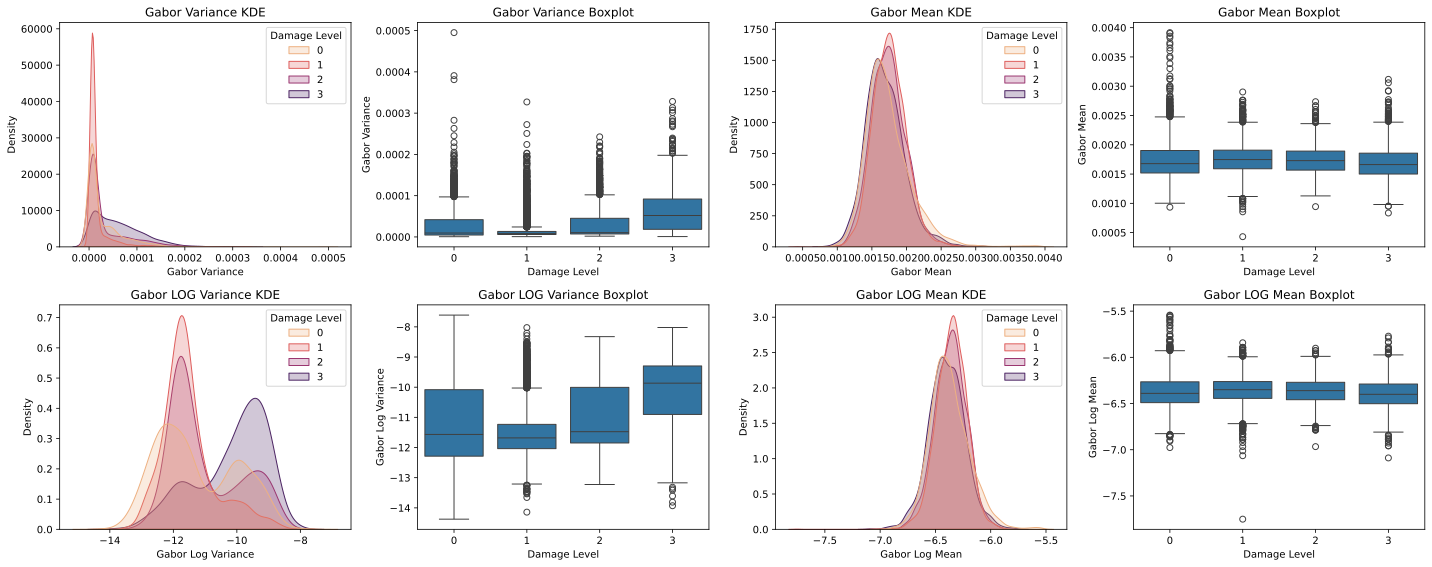

In [ ]:
# Now we will plot the distribution of the Gabor Filter
plt.figure(figsize=(20, 8))

ax5=plt.subplot(2, 4, 1)
sns.kdeplot(data=gabor_df, x='Gabor Variance', hue='Damage Level', fill=True, common_norm=False, palette='flare', ax=ax5)
ax5.set_title("Gabor Variance KDE")

ax6=plt.subplot(2, 4, 2)
sns.boxplot(data=gabor_df, x='Damage Level', y='Gabor Variance', ax=ax6)
ax6.set_title("Gabor Variance Boxplot")

ax2=plt.subplot(2, 4, 3)
sns.kdeplot(data=gabor_df, x="Gabor Mean", hue='Damage Level', fill=True, common_norm=False, palette='flare', ax=ax2)
ax2.set_title("Gabor Mean KDE")

ax4=plt.subplot(2, 4, 4)
sns.boxplot(data=gabor_df, x='Damage Level', y="Gabor Mean", ax=ax4)
ax4.set_title("Gabor Mean Boxplot")

ax1=plt.subplot(2, 4, 5)
sns.kdeplot(data=gabor_df, x='Gabor Log Variance', hue='Damage Level', fill=True, common_norm=False, palette='flare', ax=ax1)
ax1.set_title("Gabor LOG Variance KDE")

ax3=plt.subplot(2, 4, 6)
sns.boxplot(data=gabor_df, x='Damage Level', y='Gabor Log Variance', ax=ax3)
ax3.set_title("Gabor LOG Variance Boxplot")

ax7=plt.subplot(2, 4, 7)
sns.kdeplot(data=gabor_df, x='Gabor Log Mean', hue='Damage Level', fill=True, common_norm=False, palette='flare', ax=ax7)
ax7.set_title("Gabor LOG Mean KDE")

ax8=plt.subplot(2, 4, 8)
sns.boxplot(data=gabor_df, x='Damage Level', y='Gabor Log Mean', ax=ax8)
ax8.set_title("Gabor LOG Mean Boxplot")

plt.tight_layout()
plt.show()

### Local Binary Pattern

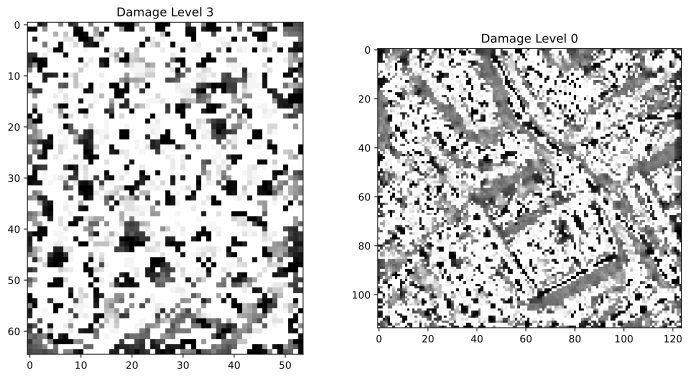

In [ ]:
# How do the images look after applying the LBP
plt.figure(figsize=(12, 6))

lbp1 = get_local_binary_pattern(data['hurricane-matthew']['images'][0], radius=3)
ax1=plt.subplot(1, 2, 1)
plt.imshow(lbp1, cmap="gray")
ax1.set_title("Damage Level 3")

lbp2 = get_local_binary_pattern(data['hurricane-matthew']['images'][3], radius=3)
ax2=plt.subplot(1, 2, 2)
plt.imshow(lbp2, cmap="gray")
ax2.set_title("Damage Level 0")
plt.show()

In [ ]:
# And now for each image
hurricane_images = data['hurricane-matthew']['images']
hurricane_labels = data['hurricane-matthew']['labels']

lbp_df= []

for img_idx, img in enumerate(hurricane_images):
    # Assuming damage levels are associated with each image
    damage_level = hurricane_labels[img_idx]  # Get the damage level for the current image
    lbp = get_local_binary_pattern(img, radius=3)
    lbp_df.append({
        "Disaster": "hurricane-matthew",
        "Image Index": img_idx,
        "Damage Level": damage_level,
        "LBP mean": np.mean(lbp),
        "LBP variance": np.var(lbp),
        "LBP Log mean": np.log(np.mean(lbp) + 0.000000000001),
        "LBP Log variance": np.log(np.var(lbp) + 0.000000000001),
    })

lbp_df = pd.DataFrame(lbp_df)
lbp_df

Disaster  Image Index  Damage Level   LBP mean  LBP variance  \
0      hurricane-matthew            0             3  18.618803     85.781755   
1      hurricane-matthew            1             0  17.093248     80.818597   
2      hurricane-matthew            2             1  18.507275     85.402725   
3      hurricane-matthew            3             0  17.523911     71.925150   
4      hurricane-matthew            4             2  15.157201     79.277857   
...                  ...          ...           ...        ...           ...   
11146  hurricane-matthew        11146             3  15.401484     74.230647   
11147  hurricane-matthew        11147             0  16.690000     86.000329   
11148  hurricane-matthew        11148             2  18.345578     88.336812   
11149  hurricane-matthew        11149             3  18.771739     87.828332   
11150  hurricane-matthew        11150             0  15.959459     77.279438   

       LBP Log mean  LBP Log variance  
0          2.924172          4.451806  
1          2.838684          4.392207  
2          2.918164          4.447378  
3          2.863566          4.275626  
4          2.718476          4.372959  
...             ...               ...  
11146      2.734464          4.307177  
11147      2.814810          4.454351  
11148      2.909389          4.481157  
11149      2.932353          4.475384  
11150      2.770052          4.347428  

[11151 rows x 7 columns]

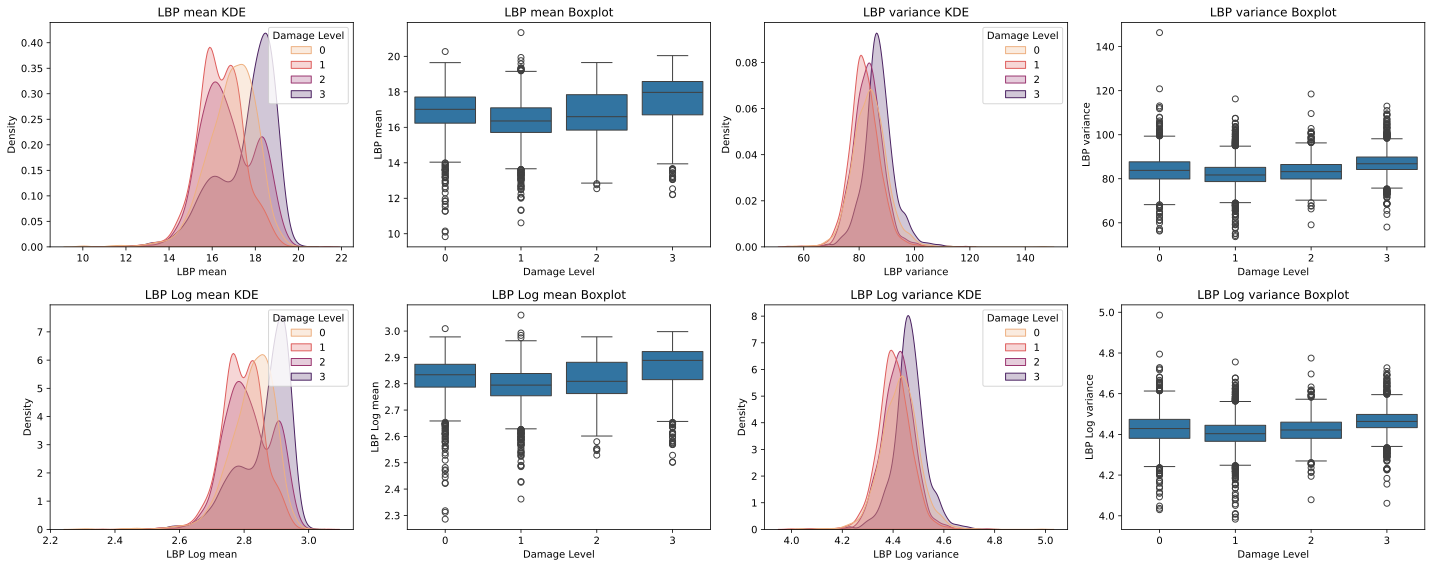

In [ ]:
plt.figure(figsize=(20, 8))

ax1=plt.subplot(2, 4, 1)
sns.kdeplot(data=lbp_df, x='LBP mean', hue='Damage Level', fill=True, common_norm=False, palette='flare', ax=ax1)
ax1.set_title("LBP mean KDE")

ax2=plt.subplot(2, 4, 2)
sns.boxplot(data=lbp_df, x='Damage Level', y='LBP mean', ax=ax2)
ax2.set_title("LBP mean Boxplot")

ax3=plt.subplot(2, 4, 3)
sns.kdeplot(data=lbp_df, x='LBP variance', hue='Damage Level', fill=True, common_norm=False, palette='flare', ax=ax3)
ax3.set_title("LBP variance KDE")

ax4=plt.subplot(2, 4, 4)
sns.boxplot(data=lbp_df, x='Damage Level', y='LBP variance', ax=ax4)
ax4.set_title("LBP variance Boxplot")

ax5=plt.subplot(2, 4, 5)
sns.kdeplot(data=lbp_df, x='LBP Log mean', hue='Damage Level', fill=True, common_norm=False, palette='flare', ax=ax5)
ax5.set_title("LBP Log mean KDE")

ax6=plt.subplot(2, 4, 6)
sns.boxplot(data=lbp_df, x='Damage Level', y='LBP Log mean', ax=ax6)
ax6.set_title("LBP Log mean Boxplot")

ax7=plt.subplot(2, 4, 7)
sns.kdeplot(data=lbp_df, x='LBP Log variance', hue='Damage Level', fill=True, common_norm=False, palette='flare', ax=ax7)
ax7.set_title("LBP Log variance KDE")

ax8=plt.subplot(2, 4, 8)
sns.boxplot(data=lbp_df, x='Damage Level', y='LBP Log variance', ax=ax8)
ax8.set_title("LBP Log variance Boxplot")

plt.tight_layout()
plt.show()

We observe the validity of filters for engineering features for our classification model again. With these features, we can now proceed to develop our logistic regression model.

## Perform the Logistic regression with multiple features (Sobel Edfe Variance, Edges 0-0.1, Edges 0.1-0.2... Gabor Log Variance, Gabor Log Mean, LBP Log Variance and LBP Log Mean).

#### First, let us optimize the code to find the best possible values for the kernel parameters and the ratio for the Gabor filter and the Local Binary Pattern.


In [ ]:
def calculate_best_parameters(data):
    best_f1 = 0
    best_freq = 0
    best_theta = 0
    best_sigma = 0

    # Perform grid search to find the best parameters
    for freq in np.arange(0.1, 1, 0.1):
        for theta in np.arange(0, 180, 10):
            for sigma in np.arange(0.1, 1, 0.1):
                df_list = []
                # Calculate the f1 score for the current parameters
                for img_idx, img in enumerate(data['images'][0:1000]):
                    # Assuming damage levels are associated with each image
                    damage_level = data['labels'][img_idx]  # Get the damage level for the current image
                    kernel = generate_gabor_kernel(theta, sigma, freq)
                    gabor = get_gabor_features(img, kernel)
                    df_list.append({
                        "Damage Level": damage_level,
                        "Gabor Log Variance": np.log(np.var(gabor) + 0.000000000001),
                        "Gabor Log Mean": np.log(np.mean(gabor) + 0.000000000001),
                    })

                df = pd.DataFrame(df_list)
                model = LogisticRegression(max_iter=1000)
                X = df[['Gabor Log Variance', 'Gabor Log Mean']]
                Y = df['Damage Level'].astype('Int64')

                X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
                model.fit(X_train, Y_train)
                Y_predict = model.predict(X_test)
                f1 = f1_score(Y_test, Y_predict, average='weighted')

                # Update the best parameters if the f1 score is higher
                if f1 > best_f1:
                    best_f1 = f1
                    best_freq = freq
                    best_theta = theta
                    best_sigma = sigma

    return best_freq, best_theta, best_sigma

In [ ]:
#this takes 20 minutes to run
frequency, theta, sigma = calculate_best_parameters(data['hurricane-matthew'])
frequency, theta, sigma

(0.7000000000000001, 120, 0.9)

In [ ]:
def calculate_best_radius(data):
    best_f1 = 0
    best_radius = 0

    # Perform grid search to find the best parameters
    for radius in np.arange(1, 10, 1):
        df_list = []
        # Calculate the f1 score for the current parameters
        for img_idx, img in enumerate(data['images'][0:1000]):
            # Assuming damage levels are associated with each image
            damage_level = data['labels'][img_idx]  # Get the damage level for the current image
            lbp = get_local_binary_pattern(img, radius=radius)
            df_list.append({
                "Damage Level": damage_level,
                "LBP Log Variance": np.log(np.var(lbp) + 0.000000000001),
                "LBP Log Mean": np.log(np.mean(lbp) + 0.000000000001),
            })

        df = pd.DataFrame(df_list)
        model = LogisticRegression(max_iter=1000)
        X = df[['LBP Log Variance', 'LBP Log Mean']]
        Y = df['Damage Level'].astype('Int64')

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        model.fit(X_train, Y_train)
        Y_predict = model.predict(X_test)
        f1 = f1_score(Y_test, Y_predict, average='weighted')

        # Update the best parameters if the f1 score is higher
        if f1 > best_f1:
            best_f1 = f1
            best_radius = radius

    return best_radius

In [ ]:
calculate_best_radius(data['hurricane-matthew'])

1

#### Let's generate the Gabor Filter and the Local Binary Pattern values with the best values for the parameters obtained.

In [ ]:
# Using the values for frequency, theta and sigma we found previously
hurricane_images = data['hurricane-matthew']['images']
hurricane_labels = data['hurricane-matthew']['labels']

gabor_df = []
frequency, theta, sigma = 0.7000000000000001, 120, 0.9
for img_idx, img in enumerate(hurricane_images):
    # Assuming damage levels are associated with each image
    damage_level = hurricane_labels[img_idx]  # Get the damage level for the current image
    kernel = generate_gabor_kernel(theta, sigma, frequency)
    gabor = get_gabor_features(img, kernel)
    total_pixels = np.size(gabor)
    gabor_df.append({
        "Disaster": "hurricane-matthew",
        "Image Index": img_idx,
        "Damage Level": damage_level,
        "Gabor Variance": np.var(gabor),
        "Gabor Log Variance": np.log(np.var(gabor) + 0.000000000001),
        "Gabor Mean": np.mean(gabor),
        "Gabor Log Mean": np.log(np.mean(gabor) + 0.000000000001),
    })

gabor_df= pd.DataFrame(gabor_df)

In [ ]:
# Usinfg the radius we found previously
hurricane_images = data['hurricane-matthew']['images']
hurricane_labels = data['hurricane-matthew']['labels']

lbp_df= []

for img_idx, img in enumerate(hurricane_images):
    # Assuming damage levels are associated with each image
    damage_level = hurricane_labels[img_idx]  # Get the damage level for the current image
    lbp = get_local_binary_pattern(img, radius=1)
    lbp_df.append({
        "Disaster": "hurricane-matthew",
        "Image Index": img_idx,
        "Damage Level": damage_level,
        "LBP Mean": np.mean(lbp),
        "LBP Variance": np.var(lbp),
        "LBP Log Mean": np.log(np.mean(lbp) + 0.000000000001),
        "LBP Log Variance": np.log(np.var(lbp) + 0.000000000001),
    })

lbp_df = pd.DataFrame(lbp_df)

### Finally, let us build and evaluate the model



In [ ]:
task_b_df = gabor_df.merge(edge_proportion_df, on=['Disaster', 'Image Index', 'Damage Level'])
task_b_df = task_b_df.merge(lbp_df, on=['Disaster', 'Image Index', 'Damage Level'])

# Prepare the data
X = task_b_df[['Sobel Edge Log Variance', 'Sobel Edge Log Mean',\
              'Edges 0-0.1', 'Edges 0.1-0.2', 'Edges 0.2-0.3', 'Edges 0.3-0.4', 'Edges 0.4-0.5', 'Edges 0.5-0.6',\
                  'Gabor Log Variance', 'Gabor Log Mean',\
                      'LBP Log Variance', 'LBP Log Mean']]

Y = task_b_df['Damage Level'].astype('Int64')

# Split the data into training and testing sets, we will use 80% of the data for training and 20% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create and train the model
edge_gabor_lbp_model = LogisticRegression(max_iter=10000)

# With this we perform a 5-fold cross-validation to evaluate the model performance using the training data and the F1 score metric
kf = KFold(n_splits=5, shuffle=True)
f1_validation = []

for train_idx, valid_idx in kf.split(X_train):
    # Split the data
    split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

    # Fit the model on the training split
    edge_gabor_lbp_model.fit(split_X_train, split_Y_train)
    Y_valid_predict = edge_gabor_lbp_model.predict(split_X_valid)

    f1 = f1_score(split_Y_valid, Y_valid_predict, average='weighted')
    f1_validation.append(f1)

print(f"Cross-validation F1 score: {np.mean(f1_validation)}")

Cross-validation F1 score: 0.48587538575292744


And testing the model on the test data we split from the entire dataset

 F1 test score: 0.48452049934860786


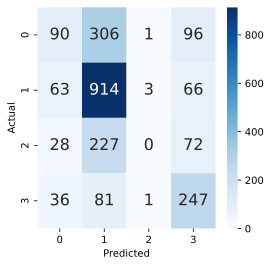

In [ ]:
Y_predict = edge_gabor_lbp_model.predict(X_test)

cm = confusion_matrix(Y_test, Y_predict)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

print(f" F1 test score: {f1_score(Y_test, Y_predict, average='weighted')}")

## **Class imbalance**; we will try using **imblearn** in 3 ways: Oversampling, undersampling, and SMOTE.

We will perform this class imbalance analysis because most of the predictions of our model are class 1, which is the class that has more images.

In [ ]:
# making a function for the logistic regression stuff

def LogRegression(X_train, Y_train, X_test, Y_test):
    # n_splits sets the number of folds to create
    kf = KFold(n_splits=5, shuffle=True)
    f1_validation = []

    model = LogisticRegression(penalty='l2', max_iter=20000)

    for train_idx, valid_idx in kf.split(X_train):
        # Split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)

        # print(split_X_train, split_Y_train)
        Y_valid_predict = model.predict(split_X_valid)
        f1 = f1_score(split_Y_valid, Y_valid_predict, average='weighted')

        print(f1)
        f1_validation.append(f1)

    print(f"Cross-validation F1 score: {np.mean(f1_validation)}")

    # Let's classify the test data
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_test)
    cm = confusion_matrix(Y_test, Y_predict)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
    plt.title('Task B Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual');
    plt.show()
    print(f" F1 test score: {f1_score(Y_test, Y_predict, average='weighted')}")

    return model

### Oversampling

This approach involves randomly sampling from the minority classes to make equal distributions for each category.

New Y_train counts:  Damage Level
2    4190
1    4190
3    4190
0    4190
Name: count, dtype: Int64
0.4711276426193413
0.4479547848872847
0.46750685546030296
0.47535326459077565
0.4733598246513118
Cross-validation F1 score: 0.4670604744418033


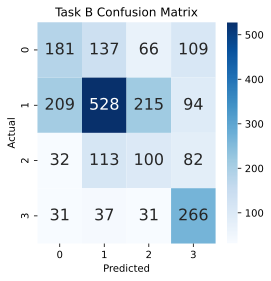

 F1 test score: 0.48528781008456584


In [ ]:
# Create an instance of RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Fit and transform the training data
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train, Y_train)

Y_train_resampled_counts = pd.Series(Y_train_resampled).value_counts()
print("New Y_train counts: ", Y_train_resampled_counts)

task_b_model = LogRegression(X_train_resampled, Y_train_resampled, X_test, Y_test)

### Undersampling

This approach involves randomly removing data from the majority class so each category has the same magnitude of data.

New Y_train counts:  Damage Level
0    1217
1    1217
2    1217
3    1217
Name: count, dtype: Int64
0.4584842606902971
0.461637997366367
0.4928816653880486
0.4749488505472977
0.4552980591913936
Cross-validation F1 score: 0.4686501666366808


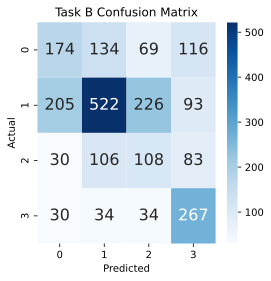

 F1 test score: 0.4842314078097266


In [ ]:
# Create an instance of RandomOverSampler
undersampler = RandomUnderSampler(random_state=42)

# Fit and transform the training data
X_train_resampled, Y_train_resampled = undersampler.fit_resample(X_train, Y_train)

Y_train_resampled_counts = pd.Series(Y_train_resampled).value_counts()
print("New Y_train counts: ", Y_train_resampled_counts)

task_b_model = LogRegression(X_train_resampled, Y_train_resampled, X_test, Y_test)

### Approaches based on NearMiss and StandardScaler

In [ ]:
# # Undersampling
# from imblearn.over_sampling import SMOTE

# # Create an instance of SMOTE
# smote = SMOTE(random_state=42)

# # Fit and transform the training data
# X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Y_train_resampled_counts = pd.Series(Y_train_resampled).value_counts()
# print("New Y_train counts: ", Y_train_resampled_counts)

# LogRegression(X_train_resampled, Y_train_resampled, X_test, Y_test)
# Create a pipeline
pipeline = make_pipeline(NearMiss(version=2), StandardScaler(), LogisticRegression())
pipeline.fit(X_train, Y_train)

# Classify and report the results
print(classification_report_imbalanced(Y_test, pipeline.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.36      0.39      0.80      0.37      0.56      0.30       493
          1       0.65      0.36      0.83      0.46      0.55      0.28      1046
          2       0.20      0.38      0.73      0.26      0.53      0.27       327
          3       0.51      0.68      0.87      0.58      0.77      0.58       365

avg / total       0.50      0.42      0.82      0.43      0.58      0.33      2231



Damage Level
1    5236
0    2631
3    1740
2    1544
Name: count, dtype: int64
New Y_train counts:  Damage Level
0    1214
1    1214
2    1214
3    1214
Name: count, dtype: Int64
0.49295756032210214
0.49384981174459724
0.48153798036068085
0.4894267955434024
0.49761989600885315
Cross-validation F1 score: 0.4910784087959271


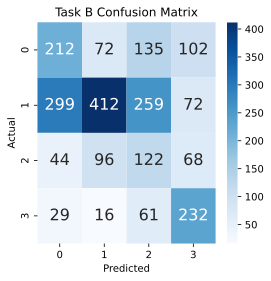

 F1 test score: 0.4509246403951281


In [ ]:
# try it with the features we calculated previously
np.random.seed(100)

test_df = gabor_df.merge(edge_proportion_df, on=['Disaster', 'Image Index', 'Damage Level'])
test_df = test_df.merge(lbp_df, on=['Disaster', 'Image Index', 'Damage Level'])

# Prepare the data
X = test_df[['Sobel Edge Log Variance', 'Sobel Edge Log Mean',\
              'Edges 0-0.1', 'Edges 0.1-0.2', 'Edges 0.2-0.3', 'Edges 0.3-0.4', 'Edges 0.4-0.5', 'Edges 0.5-0.6',\
                  'Gabor Log Variance', 'Gabor Log Mean',\
                      'LBP Log Variance', 'LBP Log Mean']]
Y = test_df['Damage Level'].astype('Int64')

# Split the data into training and testing sets, we will use 80% of the data for training and 20% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

dl_values = test_df['Damage Level'].value_counts()
print(dl_values)

# Create an instance of SMOTE
# smote = SMOTE(random_state=42)

# Fit and transform the training data
# X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
near_miss = NearMiss(version=2)
X_train_resampled, Y_train_resampled = near_miss.fit_resample(X_train, Y_train)

scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

Y_train_resampled_counts = pd.Series(Y_train_resampled).value_counts()
print("New Y_train counts: ", Y_train_resampled_counts)

task_b_model = LogRegression(pd.DataFrame(X_train_resampled), Y_train_resampled, X_test, Y_test)

1 and 3 seem to be sources of error. Let us try all the features we have gathered so far:
- Average Red, Green and Blue value
- Variance of the Red, Green, and Blue values
- Log Mean Value of the Sobel Edge filter
- Log Variance of the Sobel Edge Filter
- Proportion of counts in different bins for the Sobel Edge Filter
- Log Mean Value of the Gabor Filter
- Log Variance of the Gabor Filter
- Log Mean Value of the Local Binary Pattern
- Log Variance of the Local Binary Pattern

Damage Level
1    5236
0    2631
3    1740
2    1544
Name: count, dtype: int64
New Y_train counts:  Damage Level
0    1214
1    1214
2    1214
3    1214
Name: count, dtype: Int64
0.581070207385284
0.5649201671266818
0.5828360109682934
0.5734332548905974
0.568979284407484
Cross-validation F1 score: 0.574247784955668


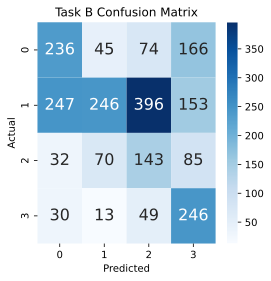

 F1 test score: 0.3837716024823189


In [ ]:
#combine sobel edge dataframe with color dataframe
test_df = gabor_df.merge(edge_proportion_df, on=['Disaster', 'Image Index', 'Damage Level'])
test_df = test_df.merge(lbp_df, on=['Disaster', 'Image Index', 'Damage Level'])
test_df = test_df.merge(color_df, on=['Disaster', 'Image Index', 'Damage Level'])

# Prepare the data
X = test_df[['Mean Red Value', 'Mean Green Value', 'Mean Blue Value',\
              'Var Red Value', 'Var Green Value', 'Var Blue Value',\
                  'Sobel Edge Log Variance', 'Sobel Edge Log Mean',\
                      'Edges 0-0.1', 'Edges 0.1-0.2', 'Edges 0.2-0.3', 'Edges 0.3-0.4', 'Edges 0.4-0.5', 'Edges 0.5-0.6',\
                          'Gabor Log Variance', 'Gabor Log Mean',\
                              'LBP Log Variance', 'LBP Log Mean']]
Y = test_df['Damage Level'].astype('Int64')

# Split the data into training and testing sets, we will use 80% of the data for training and 20% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

dl_values = test_df['Damage Level'].value_counts()
print(dl_values)

# Create an instance of SMOTE
# smote = SMOTE(random_state=42)

# Fit and transform the training data
# X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
#Under sampling taken from example on imblearn
near_miss = NearMiss(version=2)
X_train_resampled, Y_train_resampled = near_miss.fit_resample(X_train, Y_train)

scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

Y_train_resampled_counts = pd.Series(Y_train_resampled).value_counts()
print("New Y_train counts: ", Y_train_resampled_counts)

task_b_model = LogRegression(pd.DataFrame(X_train_resampled), Y_train_resampled, X_test, Y_test)

Although the cross-validation F1 increases when adding the color-based features, the test score decreases. In this sense, we define the features extracted from the different filters based on texture as crucial for our model.

Now we define some code to create ROC curves for each damage level

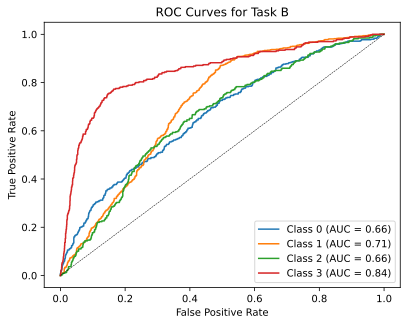

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

def generate_rocs(model, X_test, Y_test):
  # Predict probabilities for each class
  y_score = model.decision_function(X_test)

  # Binarize the labels for creating ROC curves
  y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3])

  # Set up plot
  plt.figure()

  # Generate ROC curve and AUC for each class
  for i in range(4):
      fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
      auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
      plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc:.2f})")

  # Plot configuration
  plt.plot([0, 1], [0, 1], 'k--', lw=0.5)  # Dashed diagonal line for reference
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curves for Task B")
  plt.legend(loc="best")
  plt.show()

generate_rocs(task_b_model, X_test, Y_test)

# Final models and test results

In [ ]:
# Load test data
from data_utils import get_images, get_labels, load_images
from feature_utils import get_sobel_features, get_gabor_features, generate_gabor_kernel, get_local_binary_pattern
task_a_test = load_images('/content/drive/MyDrive/Colab Notebooks/Graduate project/satellite-image-data/test_images_flooding-fire.npz')
task_b_test = load_images('/content/drive/MyDrive/Colab Notebooks/Graduate project/satellite-image-data/test_images_hurricane-matthew.npz')

#### Task A

In [ ]:
midwest_socal_df['Log Sobel Mean'] = np.log(midwest_socal_df['Sobel Edge Mean'].astype(float)+0.000000000000000001)
midwest_socal_df['Log Sobel Var'] = np.log(midwest_socal_df['Sobel Edge Variance'].astype(float)+0.000000000000000001)

X = midwest_socal_df[['Mean Red Value', \
                      'Mean Green Value',\
                      'Mean Blue Value', \
                      'Var Red Value',\
                      'Var Green Value',\
                      'Var Blue Value',\
                      'Var Lightness',\
                      'Log Sobel Mean',\
                      'Log Sobel Var'
                      ]]

Y = midwest_socal_df['Disaster']

In [ ]:
print(len(task_a_test))
# Total images
all_images = {}

print(all_images.keys())

# Dictionary to store average RGB values for each image
summary_rgb_values = {}

for img_idx, images in enumerate(task_a_test):
    # print("IMAGES: ", len(images))
    # Assuming damage levels are associated with each image
    # Calculate average RGB values for the current image
    gray = rgb2gray(images)
    sobel = get_sobel_features(images)
    avg_red = np.mean(images[:, :, 0])  # Calculate mean red value
    avg_green = np.mean(images[:, :, 1])  # Calculate mean green value
    avg_blue = np.mean(images[:, :, 2])  # Calculate mean blue value
    var_red = np.var(images[:, :, 0])  # Calculate variance of red value
    var_green = np.var(images[:, :, 1])    # Calculate variance of green value
    var_blue = np.var(images[:, :, 2]) # Calculate variance of blue value
    var_light = np.var(gray) # Calculate the variance of the gray scaled image


    # Store average RGB values in the dictionary
    summary_rgb_values[img_idx] = {
        "Image Index": img_idx,
        "Mean Red Value": avg_red,
        "Mean Green Value": avg_green,
        "Mean Blue Value": avg_blue,
        "Var Red Value": var_red,
        "Var Green Value": var_green,
        "Var Blue Value": var_blue,
        "Var Lightness" : var_light,
        "Log Sobel Var": np.log(np.var(sobel) + 0.000000000001),
        "Log Sobel Mean": np.log(np.mean(sobel) + 0.000000000001),
    }

test_color_df = pd.DataFrame(summary_rgb_values)

# Transpose the DataFrame
test_color_df = test_color_df.transpose()

# Reset the index to ensure proper indexing
test_color_df = test_color_df.reset_index(drop=True)

# Display the resulting DataFrame
display(test_color_df)

3847
dict_keys([])


Image Index  Mean Red Value  Mean Green Value  Mean Blue Value  \
0             0.0      120.082456        139.956140       135.542105   
1             1.0       87.244859        117.971726       106.290720   
2             2.0       54.643060         83.537486        63.991913   
3             3.0      138.629916        152.584139       155.019987   
4             4.0       92.978126        112.989408       109.935298   
...           ...             ...               ...              ...   
3842       3842.0       65.169324         89.916982        77.749795   
3843       3843.0       57.512749         83.301829        71.151330   
3844       3844.0       62.125746         88.792451        77.870423   
3845       3845.0       93.855414        108.702535        99.686428   
3846       3846.0       67.123076         93.514240        79.672722   

      Var Red Value  Var Green Value  Var Blue Value  Var Lightness  \
0       1011.472148       917.722638      860.356999       0.014240   
1       2511.656224      1547.421143     2270.554957       0.027213   
2        279.150627       219.650999      489.257858       0.003648   
3       2311.170581      2084.918614     2610.089220       0.033112   
4        990.698117       909.971797     1058.345802       0.014202   
...             ...              ...             ...            ...   
3842     306.483577       249.381732      605.697055       0.004234   
3843     245.466024       240.168045      460.092953       0.003825   
3844     288.658441       210.136078      616.950196       0.003620   
3845    1156.167715      1106.323734     1286.304074       0.017196   
3846     506.886253       524.887420      600.224632       0.007810   

      Log Sobel Var  Log Sobel Mean  
0         -5.110632       -2.883919  
1         -5.709182       -3.261682  
2         -8.057602       -3.808463  
3         -5.737020       -2.856748  
4         -6.120292       -3.076592  
...             ...             ...  
3842      -7.783133       -3.861984  
3843      -7.747757       -3.696929  
3844      -7.964466       -3.827093  
3845      -6.054692       -3.013471  
3846      -7.106029       -3.537038  

[3847 rows x 10 columns]

In [ ]:
# Fitting our best model for Task A
X = midwest_socal_df[['Mean Red Value', \
                      'Mean Green Value',\
                      'Mean Blue Value', \
                      'Var Red Value',\
                      'Var Green Value',\
                      'Var Blue Value',\
                      'Var Lightness',\
                      'Log Sobel Mean',\
                      'Log Sobel Var'
                        ]]
Y = midwest_socal_df['Disaster']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
multiple_feature_model = LogisticRegression(max_iter=1000, penalty='l2', C=.5)
multiple_feature_model.fit(X_train, Y_train)

LogisticRegression(C=0.5, max_iter=1000)

In [ ]:
# Run predictions

X_test = test_color_df[['Mean Red Value', 'Mean Green Value', 'Mean Blue Value','Var Red Value', 'Var Green Value', 'Var Blue Value', 'Var Lightness', 'Log Sobel Mean', 'Log Sobel Var']]

model = multiple_feature_model

predictions = model.predict(X_test)
predictions_series = pd.Series(predictions, name='pred')

replacement_dict = {
    "midwest-flooding": 0,  # Convert "midwest-flooding" to 0
    "socal-fire": 1         # Convert "socal-fire" to 1
}

predictions_series = predictions_series.replace(replacement_dict)

predictions_series.to_csv("test_images_flooding-fire_predictions.csv", index=False)


## Task B

In [ ]:
test_edge_proportion_df= []

for img_idx, img in enumerate(task_b_test):
    # Assuming damage levels are associated with each image
    sobel_edge = get_sobel_features(img)
    total_pixels = np.size(sobel_edge)
    test_edge_proportion_df.append({
        "Image Index": img_idx,
        "Sobel Edge Log Variance": np.log(np.var(sobel_edge) + 0.000000000001),
        "Sobel Edge Log Mean": np.log(np.mean(sobel_edge) + 0.000000000001),
        "Edges 0-0.1": np.sum((sobel_edge >= 0) & (sobel_edge < 0.1)) / total_pixels,
        "Edges 0.1-0.2": np.sum((sobel_edge >= 0.1) & (sobel_edge < 0.2)) / total_pixels,
        "Edges 0.2-0.3": np.sum((sobel_edge >= 0.2) & (sobel_edge < 0.3)) / total_pixels,
        "Edges 0.3-0.4": np.sum((sobel_edge >= 0.3) & (sobel_edge < 0.4)) / total_pixels,
        "Edges 0.4-0.5": np.sum((sobel_edge >= 0.4) & (sobel_edge < 0.5)) / total_pixels,
        "Edges 0.5-0.6": np.sum((sobel_edge >= 0.5) & (sobel_edge < 0.6)) / total_pixels,
        "Edges 0.6-0.7": np.sum((sobel_edge >= 0.6) & (sobel_edge < 0.7)) / total_pixels,
        "Edges 0.7-0.8": np.sum((sobel_edge >= 0.7) & (sobel_edge < 0.8)) / total_pixels,
        "Edges 0.8-0.9": np.sum((sobel_edge >= 0.8) & (sobel_edge < 0.9)) / total_pixels,
        "Total": total_pixels
    })

test_edge_proportion_df= pd.DataFrame(test_edge_proportion_df)
test_edge_proportion_df

# Using the values for frequency, theta and sigma we found previously
test_gabor_df = []
frequency, theta, sigma = 0.7000000000000001, 120, 0.9
for img_idx, img in enumerate(task_b_test):
    # Assuming damage levels are associated with each image
    kernel = generate_gabor_kernel(theta, sigma, frequency)
    gabor = get_gabor_features(img, kernel)
    total_pixels = np.size(gabor)
    test_gabor_df.append({
        "Image Index": img_idx,
        "Gabor Variance": np.var(gabor),
        "Gabor Log Variance": np.log(np.var(gabor) + 0.000000000001),
        "Gabor Mean": np.mean(gabor),
        "Gabor Log Mean": np.log(np.mean(gabor) + 0.000000000001),
    })

test_gabor_df= pd.DataFrame(test_gabor_df)

# Usinfg the radius we found previously
test_lbp_df= []

for img_idx, img in enumerate(task_b_test):
    # Assuming damage levels are associated with each image
    lbp = get_local_binary_pattern(img, radius=1)
    test_lbp_df.append({
        "Image Index": img_idx,
        "LBP Mean": np.mean(lbp),
        "LBP Variance": np.var(lbp),
        "LBP Log Mean": np.log(np.mean(lbp) + 0.000000000001),
        "LBP Log Variance": np.log(np.var(lbp) + 0.000000000001),
    })

test_lbp_df = pd.DataFrame(test_lbp_df)

#combine sobel edge dataframe with color dataframe
test_b_df = test_gabor_df.merge(test_edge_proportion_df, on=['Image Index'])
test_b_df = test_b_df.merge(test_lbp_df, on=['Image Index'])
test_b_df = test_b_df.merge(test_color_df, on=['Image Index'])

In [ ]:
# Fit the model
X = task_b_df[['Sobel Edge Log Variance', 'Sobel Edge Log Mean',\
              'Edges 0-0.1', 'Edges 0.1-0.2', 'Edges 0.2-0.3', 'Edges 0.3-0.4', 'Edges 0.4-0.5', 'Edges 0.5-0.6',\
                  'Gabor Log Variance', 'Gabor Log Mean',\
                      'LBP Log Variance', 'LBP Log Mean']]

Y = task_b_df['Damage Level'].astype('Int64')

# Split the data into training and testing sets, we will use 80% of the data for training and 20% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

oversampler = RandomOverSampler(random_state=42)

# Fit and transform the training data
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train, Y_train)

task_b_model = LogisticRegression(penalty='l2', max_iter=10000)
task_b_model.fit(X_train_resampled, Y_train_resampled)

LogisticRegression(max_iter=10000)

In [ ]:
# Run predictions

# Prepare the data
X_test = test_b_df[['Sobel Edge Log Variance', 'Sobel Edge Log Mean',\
              'Edges 0-0.1', 'Edges 0.1-0.2', 'Edges 0.2-0.3', 'Edges 0.3-0.4', 'Edges 0.4-0.5', 'Edges 0.5-0.6',\
                  'Gabor Log Variance', 'Gabor Log Mean',\
                      'LBP Log Variance', 'LBP Log Mean']]

model = task_b_model

predictions = model.predict(X_test)
predictions_series = pd.Series(predictions, name='pred')

predictions_series.to_csv("test_images_hurricane-matthew_predictions.csv", index=False)